## 라이브러리 import

In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import os, random, time, gc, warnings

from tqdm import tqdm_notebook

import lightgbm as lgbm
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor

from sklearn.feature_selection import RFECV

from sklearn.cluster import KMeans

from datetime import datetime

from math import sqrt
import io

warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

# 데이터 불러오기

* 같은 상황에서 수집한 데이터(05032, 05034)가 2 세트 더 있었지만 CycleTime 분포가 달라 제외

In [3]:
#구글 드라이브 마운트
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
#데이터 로드
import pickle

with open('/content/gdrive/My Drive/05031-가공후-ct.pkl', 'rb') as f:

    df_1 = pickle.load(f)

with open('/content/gdrive/My Drive/05033-가공후-ct.pkl', 'rb') as f:

    df_2 = pickle.load(f)

print('05031 dataSet:',len(df_1),'\n05033 dataSet:',len(df_2))

05031 dataSet: 385 
05033 dataSet: 484


# 데이터 가공

* FIFO, WIP=20 을 따르게 Uid 세팅(공장 모형은 FIFO를 가정하였지만, 실제로는 순서가 섞이는 부분이 있어 가정을 따라 시간 데이터를 시계열 순서로 정렬했었음)

## 05031 datda 가공

In [8]:
df_dropped_resetIdx = df_1.copy()

In [9]:
# FIFO, WIP=20 을 따르게 Uid 세팅

conwip=20

Uid_list = ['c37b9728', "c37b7dfe", "c37b84f4", "c37b9e2f", "c37b83cb",  "c37b9987",  "c37b770b" ,"c37ba2e1", "c37ba1b6", "c37ba1af", "c37b7e02",
            "c37b7970" , "c37b81a9" , "c37b877b", "c37b9aab", "c37b75d8", "c37b81a6" , "c37b997a", "c37b82d7", "c37b7a6e" ]

df_dropped_resetIdx['Uid'] = 'a'

for i,j in enumerate(df_dropped_resetIdx['Uid']):
  if (i % 20) == 0:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 1:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 2:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 3:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 4:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 5:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 6:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 7:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 8:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 9:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 10:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 11:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 12:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 13:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 14:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 15:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 16:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 17:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 18:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 19:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]

In [11]:
#컬럼명 변경(범위 가정 변경)
df_dropped_resetIdx=df_dropped_resetIdx.rename({'inm1':'m3m1'},axis='columns')

df_dropped_resetIdx.head()

,Time,m3m1,m1_buffer,m1m2,m2buffer,m2m3,m3buffer,total,CycleTime_cycle1,CycleTime_cycle2,CycleTime_cycle3,CycleTime_cycle4,CycleTime_cycle5,Uid
0,45741.99996,9,6,1,3,1,0,"[[c37b83cb, c37ba1b6, c37b7970, c37b82d7, c37b...",-45727.47996,-5837.68992,-5476.75999,-5103.91995,-4763.39997,c37b9728
1,0.00000,20,0,0,0,0,0,"[[], [], [], [], []]",7.22000,39918.02997,40285.63001,40658.95996,40990.85999,c37b7dfe
2,0.00000,20,0,0,0,0,0,"[[], [], [], [], []]",5.68000,39936.76000,40298.44002,40685.35000,41008.35998,c37b84f4
3,45612.00003,3,11,0,5,0,1,"[[c37b7e02, c37b82d7, c37b9728, c37b84f4, c37b...",-45606.29003,-5656.22006,-5300.90001,-4921.20001,-4581.60999,c37b9e2f
4,45778.99998,9,2,1,6,1,1,"[[c37b75d8, c37ba1af], [c37b83cb], [c37b877b, ...",-45761.01998,-5799.61998,-5437.22995,-5067.36996,-4733.52998,c37b83cb


In [19]:
# 개별 Product 위치 파악

happy_list=[]

for i in df_dropped_resetIdx['total']:
  hello_list=[]
  for j in range(0,5):
    for k in i[j]:
      try :
        hello_list.append(k)
      except :
        pass
  happy_list.append(hello_list)

df_dropped_resetIdx['m3m1_product'] = 'a'
df_dropped_resetIdx['m1_buffer_product'] = 'a'
df_dropped_resetIdx['m1m2_product'] = 'a'
df_dropped_resetIdx['m2buffer_product'] = 'a'
df_dropped_resetIdx['m2m3_product'] = 'a'
df_dropped_resetIdx['m3buffer_product'] = 'a'

df_dropped_resetIdx['conwip'] = 1

for i,j in enumerate(df_dropped_resetIdx['Time']):
  df_dropped_resetIdx['m3m1_product'][i] = list(set(Uid_list) - set(happy_list[i]))
  df_dropped_resetIdx['conwip'][i] = (len(list(set(Uid_list) - set(happy_list[i]))) + len(happy_list[i]))

  df_dropped_resetIdx['m1_buffer_product'][i] = df_dropped_resetIdx["total"][i][0]
  
  df_dropped_resetIdx['m1m2_product'][i] = df_dropped_resetIdx["total"][i][1]
  
  df_dropped_resetIdx['m2buffer_product'][i] = df_dropped_resetIdx["total"][i][2]
  
  df_dropped_resetIdx['m2m3_product'][i] = df_dropped_resetIdx["total"][i][3]
  
  df_dropped_resetIdx['m3buffer_product'][i] = df_dropped_resetIdx["total"][i][4]

df_dropped_resetIdx.head()

,Time,m3m1,m1_buffer,m1m2,m2buffer,m2m3,m3buffer,total,CycleTime_cycle1,CycleTime_cycle2,CycleTime_cycle3,CycleTime_cycle4,CycleTime_cycle5,Uid,m3m1_product,m1_buffer_product,m1m2_product,m2buffer_product,m2m3_product,m3buffer_product,conwip
0,45741.99996,9,6,1,3,1,0,"[[c37b83cb, c37ba1b6, c37b7970, c37b82d7, c37b...",-45727.47996,-5837.68992,-5476.75999,-5103.91995,-4763.39997,c37b9728,"[c37b877b, c37ba2e1, c37b7dfe, c37b9aab, c37b7...","[c37b83cb, c37ba1b6, c37b7970, c37b82d7, c37b7...",[c37b997a],"[c37b9728, c37b84f4, c37b9987]",[c37b82d7],[],21
1,0.00000,20,0,0,0,0,0,"[[], [], [], [], []]",7.22000,39918.02997,40285.63001,40658.95996,40990.85999,c37b7dfe,"[c37b877b, c37b75d8, c37b770b, c37b84f4, c37b9...",[],[],[],[],[],20
2,0.00000,20,0,0,0,0,0,"[[], [], [], [], []]",5.68000,39936.76000,40298.44002,40685.35000,41008.35998,c37b84f4,"[c37b877b, c37b75d8, c37b770b, c37b84f4, c37b9...",[],[],[],[],[],20
3,45612.00003,3,11,0,5,0,1,"[[c37b7e02, c37b82d7, c37b9728, c37b84f4, c37b...",-45606.29003,-5656.22006,-5300.90001,-4921.20001,-4581.60999,c37b9e2f,"[c37ba2e1, c37b7dfe, c37b7a6e, c37b81a9, c37b9...","[c37b7e02, c37b82d7, c37b9728, c37b84f4, c37b9...",[],"[c37b9728, c37b83cb, c37b9e2f, c37b81a6, c37b8...",[],[c37b770b],22
4,45778.99998,9,2,1,6,1,1,"[[c37b75d8, c37ba1af], [c37b83cb], [c37b877b, ...",-45761.01998,-5799.61998,-5437.22995,-5067.36996,-4733.52998,c37b83cb,"[c37ba2e1, c37b7dfe, c37b9aab, c37b770b, c37b7...","[c37b75d8, c37ba1af]",[c37b83cb],"[c37b877b, c37b9987, c37b997a, c37ba1b6, c37b7...",[c37b84f4],[c37b9728],20


In [20]:
#Product별 One-hot 인코딩(데이터 Feature가 적어 카테고리형 변수를 모두 원핫인코딩으로 변환해도 무리가 없음)

df_3=df_dropped_resetIdx.copy()

df_3['CycleTime'] = 1.1
df_3_2 = df_3.copy()
df_3_3 = df_3.copy()
df_3_4 = df_3.copy()
df_3_5 = df_3.copy()

for i,j in enumerate(df_3["Time"]):
  df_3['CycleTime'][i] = df_3['CycleTime_cycle1'][i]
df_3['CycleTime_cycle1'] = 1
df_3['CycleTime_cycle2'] = 0
df_3['CycleTime_cycle3'] = 0
df_3['CycleTime_cycle4'] = 0
df_3['CycleTime_cycle5'] = 0

for i,j in enumerate(df_3_2["Time"]):
  df_3_2['CycleTime'][i] = df_3_2['CycleTime_cycle2'][i]
df_3_2['CycleTime_cycle1'] = 0
df_3_2['CycleTime_cycle2'] = 1
df_3_2['CycleTime_cycle3'] = 0
df_3_2['CycleTime_cycle4'] = 0
df_3_2['CycleTime_cycle5'] = 0

for i,j in enumerate(df_3_3["Time"]):
  df_3_3['CycleTime'][i] = df_3_3['CycleTime_cycle3'][i]
df_3_3['CycleTime_cycle1'] = 0
df_3_3['CycleTime_cycle2'] = 0
df_3_3['CycleTime_cycle3'] = 1
df_3_3['CycleTime_cycle4'] = 0
df_3_3['CycleTime_cycle5'] = 0

for i,j in enumerate(df_3_4["Time"]):
  df_3_4['CycleTime'][i] = df_3_4['CycleTime_cycle4'][i]
df_3_4['CycleTime_cycle1'] = 0
df_3_4['CycleTime_cycle2'] = 0
df_3_4['CycleTime_cycle3'] = 0
df_3_4['CycleTime_cycle4'] = 1
df_3_4['CycleTime_cycle5'] = 0

for i,j in enumerate(df_3_5["Time"]):
  df_3_5['CycleTime'][i] = df_3_5['CycleTime_cycle5'][i]
df_3_5['CycleTime_cycle1'] = 0
df_3_5['CycleTime_cycle2'] = 0
df_3_5['CycleTime_cycle3'] = 0
df_3_5['CycleTime_cycle4'] = 0
df_3_5['CycleTime_cycle5'] = 1


In [24]:
# CycleTime이 비정상적인 행 제거
df_777 = df_3.append([df_3_2,df_3_3,df_3_4,df_3_5])
df_777 = df_777[df_777['CycleTime']!=1.1]
df_777 = df_777[df_777['CycleTime']>50]
df_777 = df_777[df_777['CycleTime']<3000]

df_777 = df_777.reset_index(drop=True)
df_1_completed=df_777.copy()
df_1_completed

,Time,m3m1,m1_buffer,m1m2,m2buffer,m2m3,m3buffer,total,CycleTime_cycle1,CycleTime_cycle2,CycleTime_cycle3,CycleTime_cycle4,CycleTime_cycle5,Uid,m3m1_product,m1_buffer_product,m1m2_product,m2buffer_product,m2m3_product,m3buffer_product,conwip,CycleTime
0,39598.99996,8,12,0,0,0,0,"[[c37b82d7, c37b997a, c37b81a9, c37ba1b6, c37b...",1,0,0,0,0,c37b7e02,"[c37ba2e1, c37b7dfe, c37b9728, c37b83cb, c37b7...","[c37b82d7, c37b997a, c37b81a9, c37ba1b6, c37b9...",[],[],[],[],21,124.61003
1,39606.00001,7,13,0,0,0,0,"[[c37b877b, c37b82d7, c37b997a, c37b81a9, c37b...",1,0,0,0,0,c37b7970,"[c37ba2e1, c37b7dfe, c37b9728, c37b83cb, c37b7...","[c37b877b, c37b82d7, c37b997a, c37b81a9, c37ba...",[],[],[],[],22,130.71000
2,39625.00002,6,13,0,1,0,0,"[[c37b7e02, c37b82d7, c37b997a, c37b81a9, c37b...",1,0,0,0,0,c37b81a9,"[c37ba2e1, c37b7dfe, c37b9728, c37b83cb, c37b7...","[c37b7e02, c37b82d7, c37b997a, c37b81a9, c37ba...",[],[c37b877b],[],[],23,124.17998
3,39660.00001,5,12,0,3,0,0,"[[c37b82d7, c37b997a, c37b81a9, c37ba1b6, c37b...",1,0,0,0,0,c37b877b,"[c37ba2e1, c37b7dfe, c37b9728, c37b83cb, c37b7...","[c37b82d7, c37b997a, c37b81a9, c37ba1b6, c37b9...",[],"[c37b877b, c37b7e02, c37b9987]",[],[],24,120.95996
4,39668.00001,4,13,0,3,0,0,"[[c37b877b, c37b82d7, c37b997a, c37b81a9, c37b...",1,0,0,0,0,c37b9aab,"[c37ba2e1, c37b7dfe, c37b9728, c37b83cb, c37b7...","[c37b877b, c37b82d7, c37b997a, c37b81a9, c37ba...",[],"[c37b877b, c37b7e02, c37b9987]",[],[],25,124.28998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1510,43981.35004,1,14,0,3,2,0,"[[c37b9aab, c37b9987, c37b9e2f, c37b75d8, c37b...",0,0,0,0,1,c37b9728,"[c37b877b, c37b9728, c37b770b, c37b997a, c37b8...","[c37b9aab, c37b9987, c37b9e2f, c37b75d8, c37ba...",[],"[c37b81a9, c37b83cb, c37b82d7]","[c37ba1af, c37b84f4]",[],24,1532.06996
1511,43995.21004,1,13,1,4,1,0,"[[c37b9e2f, c37b75d8, c37ba1b6, c37b7dfe, c37b...",0,0,0,0,1,c37b7dfe,"[c37b9728, c37b770b, c37b877b, c37b997a]","[c37b9e2f, c37b75d8, c37ba1b6, c37b7dfe, c37ba...",[c37b9987],"[c37b81a9, c37b83cb, c37b82d7, c37b9aab]",[c37b84f4],[],23,1530.08997
1512,44013.29002,1,14,0,4,1,0,"[[c37b9e2f, c37b75d8, c37ba1b6, c37b7dfe, c37b...",0,0,0,0,1,c37b84f4,"[c37b9728, c37b877b, c37b997a]","[c37b9e2f, c37b75d8, c37ba1b6, c37b7dfe, c37ba...",[],"[c37b83cb, c37b82d7, c37b9aab, c37b9987]",[c37b81a9],[],22,1531.22996
1513,44052.68999,2,10,0,7,1,0,"[[c37b83cb, c37b84f4, c37b7e02, c37b7a6e, c37b...",0,0,0,0,1,c37b9e2f,"[c37b9728, c37b877b, c37b997a]","[c37b83cb, c37b84f4, c37b7e02, c37b7a6e, c37b9...",[],"[c37b9aab, c37b9987, c37b9e2f, c37b75d8, c37ba...",[c37b82d7],[],21,1523.07004


In [ ]:
# 병목 머신을 파악해 수치화 시켜주는 열 생성

# df_dropped_resetIdx['Bottle_m1_buffer'] = 0
# df_dropped_resetIdx['Bottle_m2buffer'] = 0
# df_dropped_resetIdx['Bottle_m3buffer'] = 0

# df_dropped_resetIdx['Bottle_m1_buffer_2'] = 0
# df_dropped_resetIdx['Bottle_m2buffer_2'] = 0
# df_dropped_resetIdx['Bottle_m3buffer_2'] = 0

# for i, j in enumerate(df_dropped_resetIdx['Time']):
#   if i == 0:
#     pass
#   else : 
#     if (df_dropped_resetIdx['m1_buffer_product'][i] != []) & (df_dropped_resetIdx['m1_buffer_product'][i] == df_dropped_resetIdx['m1_buffer_product'][i-1]):
#       df_dropped_resetIdx['Bottle_m1_buffer'][i] = 1
#     if (df_dropped_resetIdx['m2buffer_product'][i] != []) & (df_dropped_resetIdx['m2buffer_product'][i] == df_dropped_resetIdx['m2buffer_product'][i-1]):
#       df_dropped_resetIdx['Bottle_m2buffer'][i] = 1
#     if (df_dropped_resetIdx['m3buffer_product'][i] != []) & (df_dropped_resetIdx['m3buffer_product'][i] == df_dropped_resetIdx['m3buffer_product'][i-1]):
#       df_dropped_resetIdx['Bottle_m3buffer'][i] = 1


# for i, j in enumerate(df_dropped_resetIdx['Time']):
#   if (i == 0) or (i == 1):
#     pass
#   else : 
#     if (df_dropped_resetIdx['m1_buffer_product'][i] != []) & (df_dropped_resetIdx['m1_buffer_product'][i] == df_dropped_resetIdx['m1_buffer_product'][i-1])& (df_dropped_resetIdx['m1_buffer_product'][i] == df_dropped_resetIdx['m1_buffer_product'][i-2]):
#       df_dropped_resetIdx['Bottle_m1_buffer_2'][i] = 1
#     if (df_dropped_resetIdx['m2buffer_product'][i] != []) & (df_dropped_resetIdx['m2buffer_product'][i] == df_dropped_resetIdx['m2buffer_product'][i-1])& (df_dropped_resetIdx['m2buffer_product'][i] == df_dropped_resetIdx['m2buffer_product'][i-2]):
#       df_dropped_resetIdx['Bottle_m2buffer_2'][i] = 1
#     if (df_dropped_resetIdx['m3buffer_product'][i] != []) & (df_dropped_resetIdx['m3buffer_product'][i] == df_dropped_resetIdx['m3buffer_product'][i-1])& (df_dropped_resetIdx['m3buffer_product'][i] == df_dropped_resetIdx['m3buffer_product'][i-2]):
#       df_dropped_resetIdx['Bottle_m3buffer_2'][i] = 1

# df_dropped_resetIdx.head()

In [22]:
# 'c37ba1af': 1, 'c37b81a9': 4, 'c37b877b': 5, 'c37b997a': 3, 'c37b9aab': 5, 'c37b81a6': 1, 'c37b9987': 4, 'c37b7dfe': 3, 'c37b7e02': 1, 'c37ba1b6': 4,
# 'c37b82d7': 5, 'c37b84f4': 5, 'c37b75d8': 4, 'c37b9e2f': 5, 'c37b7970': 1, 'c37ba2e1': 3, 'c37b83cb': 3, 'c37b7a6e': 4, 'c37b9728': 1, 'c37b770b': 3
# c37b7dfe -> c37b84f4 -> c37b9e2f -> c37b83cb -> c37b9987   -> c37b770b -> c37ba2e1 -> c37ba1b6 -> c37ba1af -> c37b7e02
# c37b7970 -> c37b81a9 -> c37b877b -> c37b9aab -> c37b75d8   -> c37b81a6 -> c37b997a -> c37b82d7 -> c37b7a6e -> c37b9728

# df_24['CycleTime']=1.1
# df_24['Product_type']='a'

# for i,j in enumerate(df_24['Time']):
#   if (i % (conwip*1)) == 0 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle4'][i]
#     df_24['Product_type'][i] = 'c37b9987_white_4'
#   elif (i % (conwip*3)) == 1 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle3'][i]
#     df_24['Product_type'][i] = 'c37b7dfe_green_3'
#   elif (i % (conwip*5)) == 2 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle5'][i]
#     df_24['Product_type'][i] = 'c37b84f4_black_5'
#   elif (i % (conwip*5)) == 3 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle5'][i]
#     df_24['Product_type'][i] = 'c37b9e2f_black_5'
#   elif (i % (conwip*3)) == 4 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle3'][i]
#     df_24['Product_type'][i] = 'c37b83cb_green_3'
#   elif (i % (conwip*4)) == 5 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle4'][i]
#     df_24['Product_type'][i] = 'c37b9987_white_4'


#   elif (i % (conwip*3)) == 6 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle3'][i]
#     df_24['Product_type'][i] = 'c37b770b_green_3'
#   elif (i % (conwip*3)) == 7 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle3'][i]
#     df_24['Product_type'][i] = 'c37ba2e1_green_3'
#   elif (i % (conwip*4)) == 8 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle4'][i]
#     df_24['Product_type'][i] = 'c37ba1b6_white_4'
#   elif (i % (conwip*1)) == 9 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle1'][i]
#     df_24['Product_type'][i] = 'c37ba1af_red_1'
#   elif (i % (conwip*1)) == 10 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle5'][i]
#     df_24['Product_type'][i] = 'c37b82d7_black_5'

#   elif (i % (conwip*1)) == 11 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle1'][i]
#     df_24['Product_type'][i] = 'c37b7970_red_1'
#   elif (i % (conwip*4)) == 12 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle4'][i]
#     df_24['Product_type'][i] = 'c37b81a9_white_4'
#   elif (i % (conwip*5)) == 13 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle5'][i]
#     df_24['Product_type'][i] = 'c37b877b_black_5'
#   elif (i % (conwip*5)) == 14 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle5'][i]
#     df_24['Product_type'][i] = 'c37b9aab_black_5'
#   elif (i % (conwip*4)) == 15 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle4'][i]
#     df_24['Product_type'][i] = 'c37b75d8_white_4'


#   elif (i % (conwip*1)) == 16 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle4'][i]
#     df_24['Product_type'][i] = 'c37b81a9_white_4'
#   elif (i % (conwip*3)) == 17 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle3'][i]
#     df_24['Product_type'][i] = 'c37b997a_green_3'
#   elif (i % (conwip*5)) == 18 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle5'][i]
#     df_24['Product_type'][i] = 'c37b82d7_black_5'
#   elif (i % (conwip*4)) == 19 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle5'][i]
#     df_24['Product_type'][i] = 'c37b82d7_black_5'

# df_888 = df_777.copy()

# for i,j in enumerate(df_888['Time']):
#   for n,m in enumerate(df_25['Time']):
#     if (df_888['CycleTime'][i] == df_25['CycleTime'][n]):
#       df_888['CycleTime'][i]=1.1

# df_888 = df_888[df_888['CycleTime']!=1.1]      
# df_888.reset_index(drop=True,inplace=True)

# len(df_777)-len(df_888)

## 05033 data 가공

In [25]:
df_dropped_resetIdx = df_2.copy()

In [26]:
# FIFO, WIP=20 을 따르게 Uid 세팅

conwip=20

Uid_list = ['c37b9728', "c37b7dfe", "c37b84f4", "c37b9e2f", "c37b83cb",  "c37b9987",  "c37b770b" ,"c37ba2e1", "c37ba1b6", "c37ba1af", "c37b7e02",
            "c37b7970" , "c37b81a9" , "c37b877b", "c37b9aab", "c37b75d8", "c37b81a6" , "c37b997a", "c37b82d7", "c37b7a6e" ]

df_dropped_resetIdx['Uid'] = 'a'

for i,j in enumerate(df_dropped_resetIdx['Uid']):
  if (i % 20) == 0:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 1:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 2:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 3:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 4:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 5:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 6:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 7:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 8:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 9:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 10:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 11:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 12:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 13:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 14:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 15:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 16:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 17:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 18:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 19:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]

In [27]:
#컬럼명 변경(범위 가정 변경)
df_dropped_resetIdx=df_dropped_resetIdx.rename({'inm1':'m3m1'},axis='columns')

df_dropped_resetIdx.head()

,Time,m3m1,m1_buffer,m1m2,m2buffer,m2m3,m3buffer,total,CycleTime_cycle1,CycleTime_cycle2,CycleTime_cycle3,CycleTime_cycle4,CycleTime_cycle5,Uid
0,80972.000006,2,10,1,4,2,1,"[[c37b84f4, c37b997a, c37b81a9, c37ba1b6, c37b...",-80962.203322,-6804.980048,-6479.419968,-6194.729984,-5915.270029,c37b9728
1,81038.000016,8,5,1,5,0,1,"[[c37b9aab, c37ba1af, c37b7970, c37b75d8, c37b...",-81030.310016,-6857.919974,-6536.370048,-6241.840003,-5975.490003,c37b7dfe
2,0.000000,20,0,0,0,0,0,"[[], [], [], [], []]",9.860000,74199.900013,74519.584392,74814.219984,75074.210016,c37b84f4
3,81040.999997,6,6,0,7,0,1,"[[c37b7e02, c37b9aab, c37ba1af, c37b7970, c37b...",-81030.409997,-6825.970006,-6513.910022,-6208.369955,-5954.559965,c37b9e2f
4,0.000000,20,0,0,0,0,0,"[[], [], [], [], []]",7.180000,74227.200013,74543.329965,74843.520032,75107.560016,c37b83cb


In [28]:
# 개별 Product 위치 파악

happy_list=[]

for i in df_dropped_resetIdx['total']:
  hello_list=[]
  for j in range(0,5):
    for k in i[j]:
      try :
        hello_list.append(k)
      except :
        pass
  happy_list.append(hello_list)

df_dropped_resetIdx['m3m1_product'] = 'a'
df_dropped_resetIdx['m1_buffer_product'] = 'a'
df_dropped_resetIdx['m1m2_product'] = 'a'
df_dropped_resetIdx['m2buffer_product'] = 'a'
df_dropped_resetIdx['m2m3_product'] = 'a'
df_dropped_resetIdx['m3buffer_product'] = 'a'

df_dropped_resetIdx['conwip'] = 1

for i,j in enumerate(df_dropped_resetIdx['Time']):
  df_dropped_resetIdx['m3m1_product'][i] = list(set(Uid_list) - set(happy_list[i]))
  df_dropped_resetIdx['conwip'][i] = (len(list(set(Uid_list) - set(happy_list[i]))) + len(happy_list[i]))

  df_dropped_resetIdx['m1_buffer_product'][i] = df_dropped_resetIdx["total"][i][0]
  
  df_dropped_resetIdx['m1m2_product'][i] = df_dropped_resetIdx["total"][i][1]
  
  df_dropped_resetIdx['m2buffer_product'][i] = df_dropped_resetIdx["total"][i][2]
  
  df_dropped_resetIdx['m2m3_product'][i] = df_dropped_resetIdx["total"][i][3]
  
  df_dropped_resetIdx['m3buffer_product'][i] = df_dropped_resetIdx["total"][i][4]

df_dropped_resetIdx.head()

,Time,m3m1,m1_buffer,m1m2,m2buffer,m2m3,m3buffer,total,CycleTime_cycle1,CycleTime_cycle2,CycleTime_cycle3,CycleTime_cycle4,CycleTime_cycle5,Uid,m3m1_product,m1_buffer_product,m1m2_product,m2buffer_product,m2m3_product,m3buffer_product,conwip
0,80972.000006,2,10,1,4,2,1,"[[c37b84f4, c37b997a, c37b81a9, c37ba1b6, c37b...",-80962.203322,-6804.980048,-6479.419968,-6194.729984,-5915.270029,c37b9728,"[c37b877b, c37b9728, c37b770b, c37b9e2f, c37b9...","[c37b84f4, c37b997a, c37b81a9, c37ba1b6, c37b7...",[c37b7a6e],"[c37ba2e1, c37b81a6, c37ba1af, c37b82d7]","[0.0, c37b7e02]",[0.0],24
1,81038.000016,8,5,1,5,0,1,"[[c37b9aab, c37ba1af, c37b7970, c37b75d8, c37b...",-81030.310016,-6857.919974,-6536.370048,-6241.840003,-5975.490003,c37b7dfe,"[c37b877b, c37ba2e1, c37b9728, c37b770b, c37b9...","[c37b9aab, c37ba1af, c37b7970, c37b75d8, c37b8...",[c37b81a6],"[c37b7a6e, c37b84f4, c37b81a9, c37ba1b6, c37b7...",[],[c37b82d7],20
2,0.000000,20,0,0,0,0,0,"[[], [], [], [], []]",9.860000,74199.900013,74519.584392,74814.219984,75074.210016,c37b84f4,"[c37b877b, c37b75d8, c37b770b, c37b84f4, c37b9...",[],[],[],[],[],20
3,81040.999997,6,6,0,7,0,1,"[[c37b7e02, c37b9aab, c37ba1af, c37b7970, c37b...",-81030.409997,-6825.970006,-6513.910022,-6208.369955,-5954.559965,c37b9e2f,"[c37b877b, c37ba2e1, c37b82d7, c37b770b, c37b9...","[c37b7e02, c37b9aab, c37ba1af, c37b7970, c37b7...",[],"[c37b9728, c37b7a6e, c37b84f4, c37b81a9, c37ba...",[],[c37b997a],20
4,0.000000,20,0,0,0,0,0,"[[], [], [], [], []]",7.180000,74227.200013,74543.329965,74843.520032,75107.560016,c37b83cb,"[c37b877b, c37b75d8, c37b770b, c37b84f4, c37b9...",[],[],[],[],[],20


In [29]:
#Product별 One-hot 인코딩(데이터 Feature가 적어 카테고리형 변수를 모두 원핫인코딩으로 변환해도 무리가 없음)

df_3=df_dropped_resetIdx.copy()

df_3['CycleTime'] = 1.1
df_3_2 = df_3.copy()
df_3_3 = df_3.copy()
df_3_4 = df_3.copy()
df_3_5 = df_3.copy()

for i,j in enumerate(df_3["Time"]):
  df_3['CycleTime'][i] = df_3['CycleTime_cycle1'][i]
df_3['CycleTime_cycle1'] = 1
df_3['CycleTime_cycle2'] = 0
df_3['CycleTime_cycle3'] = 0
df_3['CycleTime_cycle4'] = 0
df_3['CycleTime_cycle5'] = 0

for i,j in enumerate(df_3_2["Time"]):
  df_3_2['CycleTime'][i] = df_3_2['CycleTime_cycle2'][i]
df_3_2['CycleTime_cycle1'] = 0
df_3_2['CycleTime_cycle2'] = 1
df_3_2['CycleTime_cycle3'] = 0
df_3_2['CycleTime_cycle4'] = 0
df_3_2['CycleTime_cycle5'] = 0

for i,j in enumerate(df_3_3["Time"]):
  df_3_3['CycleTime'][i] = df_3_3['CycleTime_cycle3'][i]
df_3_3['CycleTime_cycle1'] = 0
df_3_3['CycleTime_cycle2'] = 0
df_3_3['CycleTime_cycle3'] = 1
df_3_3['CycleTime_cycle4'] = 0
df_3_3['CycleTime_cycle5'] = 0

for i,j in enumerate(df_3_4["Time"]):
  df_3_4['CycleTime'][i] = df_3_4['CycleTime_cycle4'][i]
df_3_4['CycleTime_cycle1'] = 0
df_3_4['CycleTime_cycle2'] = 0
df_3_4['CycleTime_cycle3'] = 0
df_3_4['CycleTime_cycle4'] = 1
df_3_4['CycleTime_cycle5'] = 0

for i,j in enumerate(df_3_5["Time"]):
  df_3_5['CycleTime'][i] = df_3_5['CycleTime_cycle5'][i]
df_3_5['CycleTime_cycle1'] = 0
df_3_5['CycleTime_cycle2'] = 0
df_3_5['CycleTime_cycle3'] = 0
df_3_5['CycleTime_cycle4'] = 0
df_3_5['CycleTime_cycle5'] = 1


In [30]:
# CycleTime이 비정상적인 행 제거
df_777 = df_3.append([df_3_2,df_3_3,df_3_4,df_3_5])
df_777 = df_777[df_777['CycleTime']!=1.1]
df_777 = df_777[df_777['CycleTime']>50]
df_777 = df_777[df_777['CycleTime']<3000]

df_777 = df_777.reset_index(drop=True)
df_2_completed = df_777.copy()
df_2_completed

,Time,m3m1,m1_buffer,m1m2,m2buffer,m2m3,m3buffer,total,CycleTime_cycle1,CycleTime_cycle2,CycleTime_cycle3,CycleTime_cycle4,CycleTime_cycle5,Uid,m3m1_product,m1_buffer_product,m1m2_product,m2buffer_product,m2m3_product,m3buffer_product,conwip,CycleTime
0,73871.000006,6,14,0,0,0,0,"[[c37b84f4, c37ba1af, c37b9987, c37b82d7, c37b...",1,0,0,0,0,c37b81a9,"[c37b877b, c37b7dfe, c37b9728, c37b75d8, c37b7...","[c37b84f4, c37ba1af, c37b9987, c37b82d7, c37ba...",[],[],[],[],24,137.280006
1,73897.000013,5,15,0,0,0,0,"[[c37b997a, c37b84f4, c37ba1af, c37b9987, c37b...",1,0,0,0,0,c37b877b,"[c37b877b, c37b7dfe, c37b9728, c37b75d8, c37b7...","[c37b997a, c37b84f4, c37ba1af, c37b9987, c37b8...",[],[],[],[],24,136.639965
2,73916.999971,4,16,0,0,0,0,"[[c37b997a, c37b7970, c37b84f4, c37ba1af, c37b...",1,0,0,0,0,c37b9aab,"[c37b877b, c37b7dfe, c37b9728, c37b75d8, c37b7...","[c37b997a, c37b7970, c37b84f4, c37ba1af, c37b9...",[],[],[],[],24,149.530000
3,73947.000038,3,16,0,1,0,0,"[[c37b7970, c37b877b, c37b84f4, c37ba1af, c37b...",1,0,0,0,0,c37b75d8,"[c37b7dfe, c37b9728, c37b75d8, c37b770b, c37b7...","[c37b7970, c37b877b, c37b84f4, c37ba1af, c37b9...",[],[c37b997a],[],[],24,141.639946
4,73966.000003,2,16,0,2,0,0,"[[c37b877b, c37b9e2f, c37b84f4, c37ba1af, c37b...",1,0,0,0,0,c37b81a6,"[c37b7dfe, c37b9728, c37b75d8, c37b770b, c37b7...","[c37b877b, c37b9e2f, c37b84f4, c37ba1af, c37b9...",[],"[c37b997a, c37b7970]",[],[],24,129.169978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985,79273.650013,1,15,0,3,1,0,"[[c37b75d8, c37ba1b6, c37b83cb, c37b81a9, c37b...",0,0,0,0,1,c37b7a6e,"[c37b877b, c37b7dfe, c37b84f4, c37b7a6e, c37b7...","[c37b75d8, c37ba1b6, c37b83cb, c37b81a9, c37b9...",[],"[c37b9aab, c37b770b, c37b997a]",[c37b9728],[],25,1550.999949
1986,79298.339978,1,15,0,3,0,1,"[[c37ba1b6, c37b83cb, c37b81a9, c37b9e2f, c37b...",0,0,0,0,1,c37b9728,"[c37b877b, c37b7dfe, c37b84f4, c37b7a6e, c37b7...","[c37ba1b6, c37b83cb, c37b81a9, c37b9e2f, c37b9...",[],"[c37b770b, c37b997a, c37b75d8]",[],[c37b9aab],25,1543.060042
1987,79305.999981,1,15,0,3,1,0,"[[c37b83cb, c37b81a9, c37b9e2f, c37b9aab, c37b...",0,0,0,0,1,c37b7dfe,"[c37b877b, c37b7dfe, c37b84f4, c37b7a6e, c37b7...","[c37b83cb, c37b81a9, c37b9e2f, c37b9aab, c37b7...",[],"[c37b997a, c37b75d8, c37ba1b6]",[c37b770b],[],25,1546.690035
1988,79316.920003,1,15,1,2,1,0,"[[c37b81a9, c37b9e2f, c37b9aab, c37b770b, 0.0,...",0,0,0,0,1,c37b84f4,"[c37b877b, c37b7dfe, c37b84f4, c37b7a6e, c37b7...","[c37b81a9, c37b9e2f, c37b9aab, c37b770b, 0.0, ...",[c37b83cb],"[c37b75d8, c37ba1b6]",[c37b997a],[],25,1549.280010


In [ ]:
# 병목 머신을 파악해 수치화 시켜주는 열 생성

# df_dropped_resetIdx['Bottle_m1_buffer'] = 0
# df_dropped_resetIdx['Bottle_m2buffer'] = 0
# df_dropped_resetIdx['Bottle_m3buffer'] = 0

# df_dropped_resetIdx['Bottle_m1_buffer_2'] = 0
# df_dropped_resetIdx['Bottle_m2buffer_2'] = 0
# df_dropped_resetIdx['Bottle_m3buffer_2'] = 0

# for i, j in enumerate(df_dropped_resetIdx['Time']):
#   if i == 0:
#     pass
#   else : 
#     if (df_dropped_resetIdx['m1_buffer_product'][i] != []) & (df_dropped_resetIdx['m1_buffer_product'][i] == df_dropped_resetIdx['m1_buffer_product'][i-1]):
#       df_dropped_resetIdx['Bottle_m1_buffer'][i] = 1
#     if (df_dropped_resetIdx['m2buffer_product'][i] != []) & (df_dropped_resetIdx['m2buffer_product'][i] == df_dropped_resetIdx['m2buffer_product'][i-1]):
#       df_dropped_resetIdx['Bottle_m2buffer'][i] = 1
#     if (df_dropped_resetIdx['m3buffer_product'][i] != []) & (df_dropped_resetIdx['m3buffer_product'][i] == df_dropped_resetIdx['m3buffer_product'][i-1]):
#       df_dropped_resetIdx['Bottle_m3buffer'][i] = 1


# for i, j in enumerate(df_dropped_resetIdx['Time']):
#   if (i == 0) or (i == 1):
#     pass
#   else : 
#     if (df_dropped_resetIdx['m1_buffer_product'][i] != []) & (df_dropped_resetIdx['m1_buffer_product'][i] == df_dropped_resetIdx['m1_buffer_product'][i-1])& (df_dropped_resetIdx['m1_buffer_product'][i] == df_dropped_resetIdx['m1_buffer_product'][i-2]):
#       df_dropped_resetIdx['Bottle_m1_buffer_2'][i] = 1
#     if (df_dropped_resetIdx['m2buffer_product'][i] != []) & (df_dropped_resetIdx['m2buffer_product'][i] == df_dropped_resetIdx['m2buffer_product'][i-1])& (df_dropped_resetIdx['m2buffer_product'][i] == df_dropped_resetIdx['m2buffer_product'][i-2]):
#       df_dropped_resetIdx['Bottle_m2buffer_2'][i] = 1
#     if (df_dropped_resetIdx['m3buffer_product'][i] != []) & (df_dropped_resetIdx['m3buffer_product'][i] == df_dropped_resetIdx['m3buffer_product'][i-1])& (df_dropped_resetIdx['m3buffer_product'][i] == df_dropped_resetIdx['m3buffer_product'][i-2]):
#       df_dropped_resetIdx['Bottle_m3buffer_2'][i] = 1

# df_dropped_resetIdx.head()

In [ ]:
# 'c37ba1af': 1, 'c37b81a9': 4, 'c37b877b': 5, 'c37b997a': 3, 'c37b9aab': 5, 'c37b81a6': 1, 'c37b9987': 4, 'c37b7dfe': 3, 'c37b7e02': 1, 'c37ba1b6': 4,
# 'c37b82d7': 5, 'c37b84f4': 5, 'c37b75d8': 4, 'c37b9e2f': 5, 'c37b7970': 1, 'c37ba2e1': 3, 'c37b83cb': 3, 'c37b7a6e': 4, 'c37b9728': 1, 'c37b770b': 3
# c37b7dfe -> c37b84f4 -> c37b9e2f -> c37b83cb -> c37b9987   -> c37b770b -> c37ba2e1 -> c37ba1b6 -> c37ba1af -> c37b7e02
# c37b7970 -> c37b81a9 -> c37b877b -> c37b9aab -> c37b75d8   -> c37b81a6 -> c37b997a -> c37b82d7 -> c37b7a6e -> c37b9728

# df_24['CycleTime']=1.1
# df_24['Product_type']='a'

# for i,j in enumerate(df_24['Time']):
#   if (i % (conwip*1)) == 0 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle4'][i]
#     df_24['Product_type'][i] = 'c37b9987_white_4'
#   elif (i % (conwip*3)) == 1 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle3'][i]
#     df_24['Product_type'][i] = 'c37b7dfe_green_3'
#   elif (i % (conwip*5)) == 2 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle5'][i]
#     df_24['Product_type'][i] = 'c37b84f4_black_5'
#   elif (i % (conwip*5)) == 3 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle5'][i]
#     df_24['Product_type'][i] = 'c37b9e2f_black_5'
#   elif (i % (conwip*3)) == 4 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle3'][i]
#     df_24['Product_type'][i] = 'c37b83cb_green_3'
#   elif (i % (conwip*4)) == 5 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle4'][i]
#     df_24['Product_type'][i] = 'c37b9987_white_4'


#   elif (i % (conwip*3)) == 6 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle3'][i]
#     df_24['Product_type'][i] = 'c37b770b_green_3'
#   elif (i % (conwip*3)) == 7 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle3'][i]
#     df_24['Product_type'][i] = 'c37ba2e1_green_3'
#   elif (i % (conwip*4)) == 8 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle4'][i]
#     df_24['Product_type'][i] = 'c37ba1b6_white_4'
#   elif (i % (conwip*1)) == 9 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle1'][i]
#     df_24['Product_type'][i] = 'c37ba1af_red_1'
#   elif (i % (conwip*1)) == 10 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle5'][i]
#     df_24['Product_type'][i] = 'c37b82d7_black_5'

#   elif (i % (conwip*1)) == 11 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle1'][i]
#     df_24['Product_type'][i] = 'c37b7970_red_1'
#   elif (i % (conwip*4)) == 12 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle4'][i]
#     df_24['Product_type'][i] = 'c37b81a9_white_4'
#   elif (i % (conwip*5)) == 13 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle5'][i]
#     df_24['Product_type'][i] = 'c37b877b_black_5'
#   elif (i % (conwip*5)) == 14 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle5'][i]
#     df_24['Product_type'][i] = 'c37b9aab_black_5'
#   elif (i % (conwip*4)) == 15 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle4'][i]
#     df_24['Product_type'][i] = 'c37b75d8_white_4'


#   elif (i % (conwip*1)) == 16 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle4'][i]
#     df_24['Product_type'][i] = 'c37b81a9_white_4'
#   elif (i % (conwip*3)) == 17 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle3'][i]
#     df_24['Product_type'][i] = 'c37b997a_green_3'
#   elif (i % (conwip*5)) == 18 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle5'][i]
#     df_24['Product_type'][i] = 'c37b82d7_black_5'
#   elif (i % (conwip*4)) == 19 :
#     df_24['CycleTime'][i] = df_24['CycleTime_cycle5'][i]
#     df_24['Product_type'][i] = 'c37b82d7_black_5'

# df_888 = df_777.copy()

# for i,j in enumerate(df_888['Time']):
#   for n,m in enumerate(df_25['Time']):
#     if (df_888['CycleTime'][i] == df_25['CycleTime'][n]):
#       df_888['CycleTime'][i]=1.1

# df_888 = df_888[df_888['CycleTime']!=1.1]      
# df_888.reset_index(drop=True,inplace=True)

# len(df_777)-len(df_888)

## 05031 + 05033

In [69]:
# data 통합

df_completed = pd.concat([df_1_completed, df_2_completed])

df_completed.reset_index(drop=True,inplace=True)

len(df_completed)

3505

In [70]:
#train, test set 분리

X_train, X_test, y_train, y_test = train_test_split(df_completed, df_completed['CycleTime'], test_size=0.24, shuffle=True, random_state=2021)

print(len(X_train),len(X_test))

2663 842


# 평가함수 정의

* RMSLE, RMSE, MAE

In [71]:
# 평가함수 정의
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def rmsle(y, pred):
    log_y=np.log1p(y)
    log_pred=np.log1p(pred)
    squared_error=(log_y - log_pred)**2
    rmsle=np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.10f}, RMSE: {1:.10f}, MAE: {2:.10f}'.format(rmsle_val, rmse_val, mae_val))

# 모델링

* Linear, Ridge, Decision Tree, Random Forest, XGB, Light GBM

## Train

In [72]:
# 모델에 쓰일 parameter 설정
n_splits= 5
NUM_BOOST_ROUND = 100000
SEED = 2021
lgbm_param = {'objective':'rmse',
              'boosting_type': 'gbdt',
              'random_state':2021,
              'learning_rate':0.1,
              'subsample':0.7,
              'tree_learner': 'serial',
              'colsample_bytree':0.78,
              'early_stopping_rounds':50,
              'subsample_freq': 1,
              'reg_lambda':7,
              'reg_alpha': 5,
              'num_leaves': 96,
              'seed' : SEED
            }

In [73]:
X_train.reset_index(drop=True,inplace=True)

# 선언
train_label = X_train['CycleTime']
train = X_train.copy()
drop_cols = ['CycleTime', 'Time', 'total', 'm3m1_product','conwip','m1_buffer_product' ,'m1m2_product','m2buffer_product','m2m3_product','m3buffer_product','Uid','m3m1','m1m2','m2m3']
#, 'm3m1_product','conwip','m1_buffer_product' ,'m1m2_product','m2buffer_product','m2m3_product','m3buffer_product'

# 각 모델에 대한 oof 정의
lr_oof_train = np.zeros((train.shape[0]))
ridge_oof_train = np.zeros((train.shape[0]))
lasso_oof_train = np.zeros((train.shape[0]))
dt_oof_train = np.zeros((train.shape[0]))
rf_oof_train = np.zeros((train.shape[0]))
svr_oof_train = np.zeros((train.shape[0]))
lgbm_oof_train = np.zeros((train.shape[0]))
w_oof_train = np.zeros((train.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=2021, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    
    # (0) Linear
    print("---TRAINING LINEAR---")
    lr = LinearRegression()
    
    lr.fit(X_train, y_train)
    
    lr_valid_pred = lr.predict(X_valid)
    lr_oof_train[val_ind] = lr_valid_pred    

    # (1) Ridge
    print("---TRAINING RIDGE---")
    ridge = Ridge(random_state = 2021)
    
    ridge.fit(X_train, y_train)
    
    ridge_valid_pred = ridge.predict(X_valid)
    ridge_oof_train[val_ind] = ridge_valid_pred

    # (2) Lasso
    print("---TRAINING LASSO---")
    lasso = Lasso(random_state = 2021)
    
    lasso.fit(X_train, y_train)
    
    lasso_valid_pred = lasso.predict(X_valid)
    lasso_oof_train[val_ind] = lasso_valid_pred
    
    # (3) Decision Tree
    print("---TRAINING DECISION TREE---")
    dt = DecisionTreeRegressor(random_state=2021)
    
    dt.fit(X_train, y_train)
    
    dt_valid_pred = dt.predict(X_valid)
    dt_oof_train[val_ind] = dt_valid_pred

    # (4) Random Forest
    print("---TRAINING RANDOM FOREST---")
    rf = RandomForestRegressor(random_state=2021, n_estimators=20 )
    
    rf.fit(X_train, y_train)
    
    rf_valid_pred = rf.predict(X_valid)
    rf_oof_train[val_ind] = rf_valid_pred

    # (5) XGB
    print("---TRAINING XGBRegressor---")
    xgb_wrapper = XGBRegressor(n_estimators = 1000, learning_rate = 0.05, max_depth = 15,objective='reg:squarederror', booster='gbtree',eval_metric='rmse')
    xgb_wrapper.fit(X_train, y_train)

    w_valid_pred = xgb_wrapper.predict(X_valid)
    w_oof_train[val_ind] = w_valid_pred
    
    # (6) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       verbose_eval= 5)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
    
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    print('='*80)

        
print("<Linear> OVERALL:", evaluate_regr(train_label,lr_oof_train))   
print('-'*80)
print("<Ridge> OVERALL:", evaluate_regr(train_label,ridge_oof_train))
print('-'*80)
print("<Lasso> OVERALL:", evaluate_regr(train_label,lasso_oof_train))
print('-'*80)
print("<Decision-Tree> OVERALL:", evaluate_regr(train_label,dt_oof_train))
print('-'*80)
print("<Random-Forest> OVERALL:", evaluate_regr(train_label,rf_oof_train))
print('-'*80)
print("<XGBoost> OVERALL:", evaluate_regr(train_label,w_oof_train))
print('-'*80)
print("<Light-GBM> OVERALL:", evaluate_regr(train_label,lgbm_oof_train))

---TRAINING LINEAR---
---TRAINING RIDGE---
---TRAINING LASSO---
---TRAINING DECISION TREE---
---TRAINING RANDOM FOREST---
---TRAINING XGBRegressor---
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[5]	train's rmse: 309.909	valid's rmse: 311.165
[10]	train's rmse: 202.057	valid's rmse: 203.285
[15]	train's rmse: 136.642	valid's rmse: 138.473
[20]	train's rmse: 101.753	valid's rmse: 103.697
[25]	train's rmse: 86.9009	valid's rmse: 89.3266
[30]	train's rmse: 77.122	valid's rmse: 79.5897
[35]	train's rmse: 73.7392	valid's rmse: 76.4934
[40]	train's rmse: 71.5058	valid's rmse: 74.4022
[45]	train's rmse: 70.4109	valid's rmse: 73.6067
[50]	train's rmse: 69.802	valid's rmse: 73.1655
[55]	train's rmse: 69.5187	valid's rmse: 72.839
[60]	train's rmse: 69.2629	valid's rmse: 72.6069
[65]	train's rmse: 69.1294	valid's rmse: 72.5363
[70]	train's rmse: 68.9668	valid's rmse: 72.5014
[75]	train's rmse: 68.8991	valid's rmse: 72.4128
[80]	train's rmse: 68.864	valid'

## Test

In [100]:
xgb_wrapper = XGBRegressor(n_estimators = 1000, learning_rate = 0.05, max_depth = 15,objective='reg:squarederror', booster='gbtree',eval_metric='rmse')
xgb_wrapper.fit(train.drop(drop_cols,axis=1), train_label)
w_preds=xgb_wrapper.predict(X_test.drop(drop_cols,axis=1))
print(evaluate_regr(w_preds,y_test))

RMSLE: 0.1165294643, RMSE: 73.1250925475, MAE: 56.6888611886
None


No handles with labels found to put in legend.


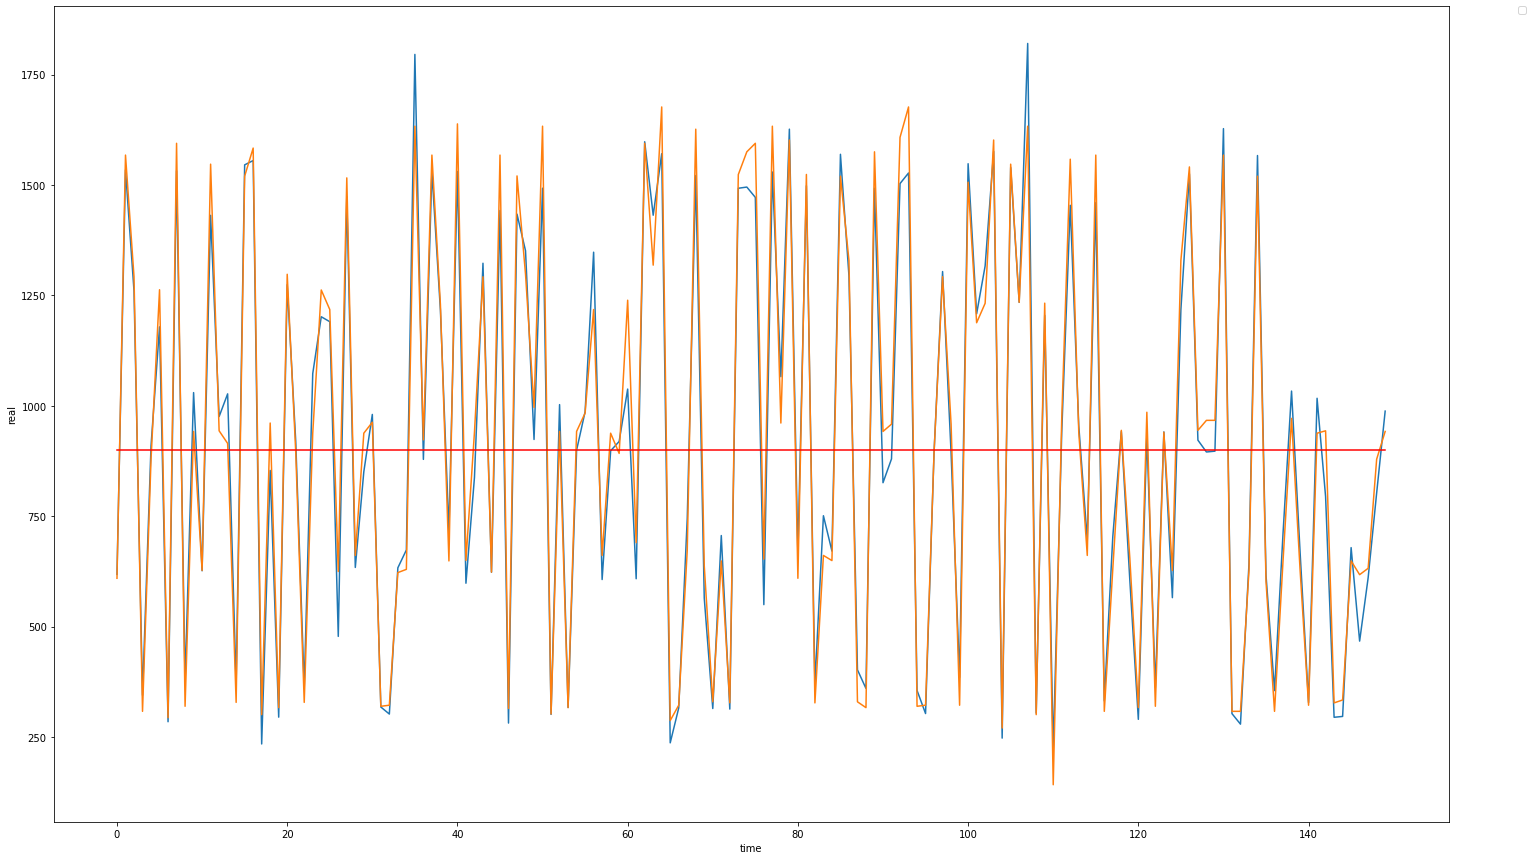

In [82]:
#train_label,lgbm_oof_train
df_11 = pd.DataFrame({'real': (y_test)[0:150],
                      'pred':(w_preds)[0:150],
                      'time': list(range(0,len(y_test)))[0:150]
                      #'product_type': df_24['Product_type'],                      
                      #'MVA_red': aa_list,
                      #'MVA_green': cc_list,
                      #'MVA_white': dd_list,
                      #'MVA_black': ee_list,
                     #'CycleTime':ct_list
                      })

plt.rcParams['figure.figsize'] = [25, 15]
sns.lineplot(data=df_11, x="time", y="real")
sns.lineplot(data=df_11, x="time", y="pred")
sns.lineplot(data=df_11, x='time', y=300*3, color = 'red')
#sns.lineplot(data=df_11, x='time', y='MVA_red', color = 'red')
#sns.lineplot(data=df_11, x='time', y='MVA_black', color = "black")
#sns.lineplot(data=df_11, x='time', y='MVA_white', color = "gray")
#sns.lineplot(data=df_11, x='time', y='MVA_green', color = "green")


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

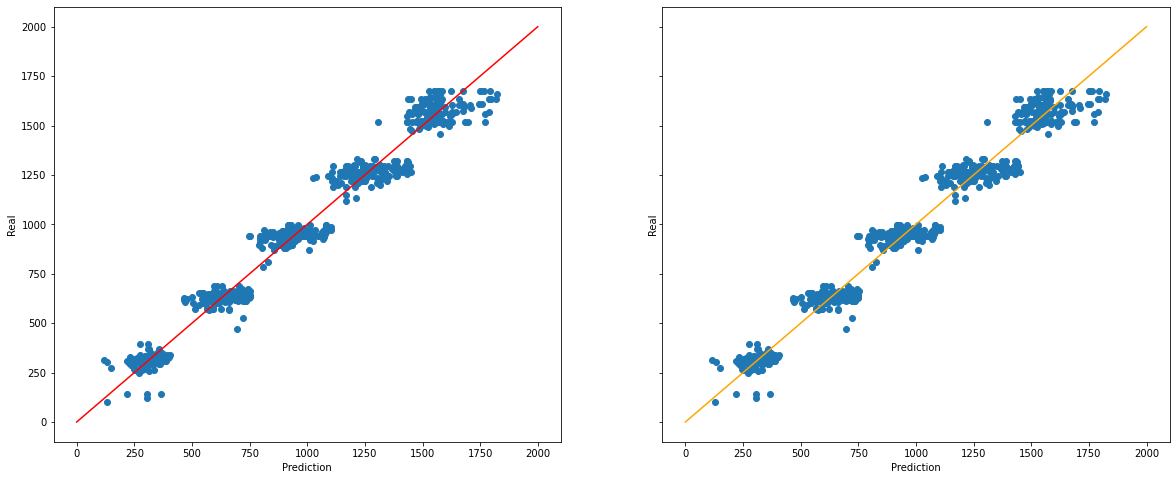

In [92]:
# 실제값과 예측값의 분포 비교
fig, axes = plt.subplots( 1,2, figsize=(20, 8), sharex=True, sharey=True)

# y=x를 그리기 위하여
x_range = np.linspace(0, 2000, 1000)

# <SUBPLOT 1> : local_train에 대한 예측/실제값 비교
axes[0].scatter( y_test, w_preds)
axes[0].set_xlabel("Prediction")
axes[0].set_ylabel("Real")

axes[1].scatter( y_test, w_preds)
axes[1].set_xlabel("Prediction")
axes[1].set_ylabel("Real")

# y=x 그리기
axes[0].plot(x_range, x_range, color='r')
axes[1].plot(x_range, x_range, color='orange')

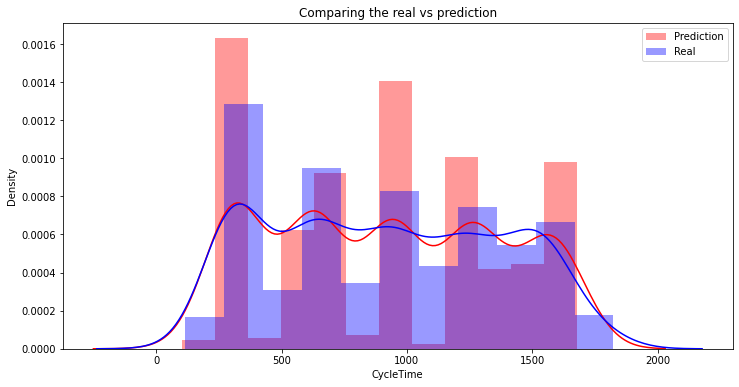

In [84]:
# 실제값 vs 예측값 비교(히스토그램)

plt.figure(figsize=(12,6))

sns.distplot(w_preds, color='r' , label='Prediction')
sns.distplot(y_test, color='b', label='Real')
plt.legend()
plt.title("Comparing the real vs prediction");

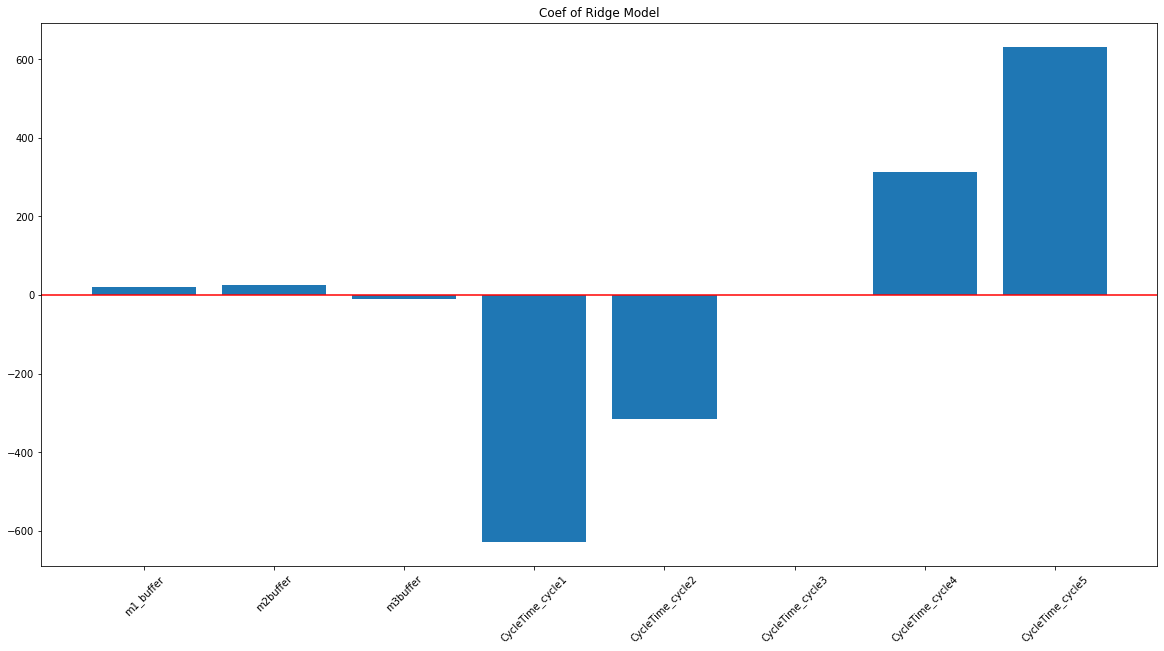

In [85]:
# Figure을 정의
plt.figure(figsize=(20,10))

# Ridge의 Coef를 barplot으로 그리기
plt.bar(train.drop(drop_cols,1).columns,  ridge.coef_ )

# y=0인 horizental한 선을 그리기
plt.axhline(y=0, color='r', linestyle='-')

plt.xticks(rotation=45)
plt.title("Coef of Ridge Model");

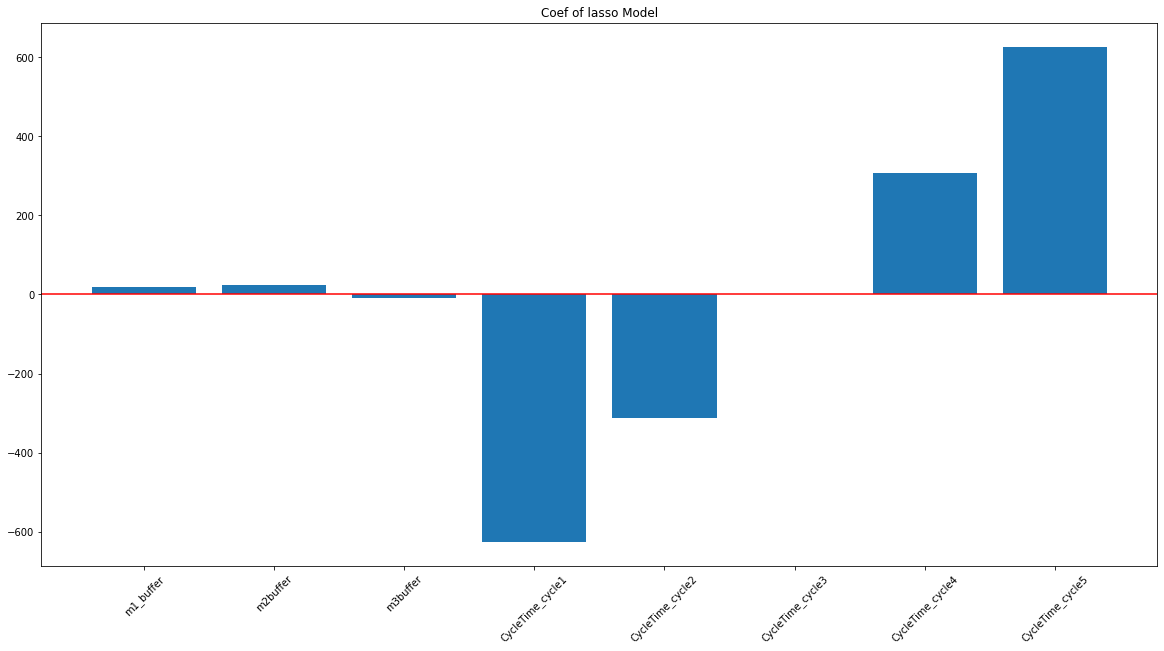

In [87]:
# Figure을 정의
plt.figure(figsize=(20,10))

# lasso의 Coef를 barplot으로 그리기
plt.bar( train.drop(drop_cols,1).columns,  lasso.coef_ )

# y=0인 horizental한 선을 그리기
plt.axhline(y=0, color='r', linestyle='-')

plt.xticks(rotation=45)
plt.title("Coef of lasso Model");

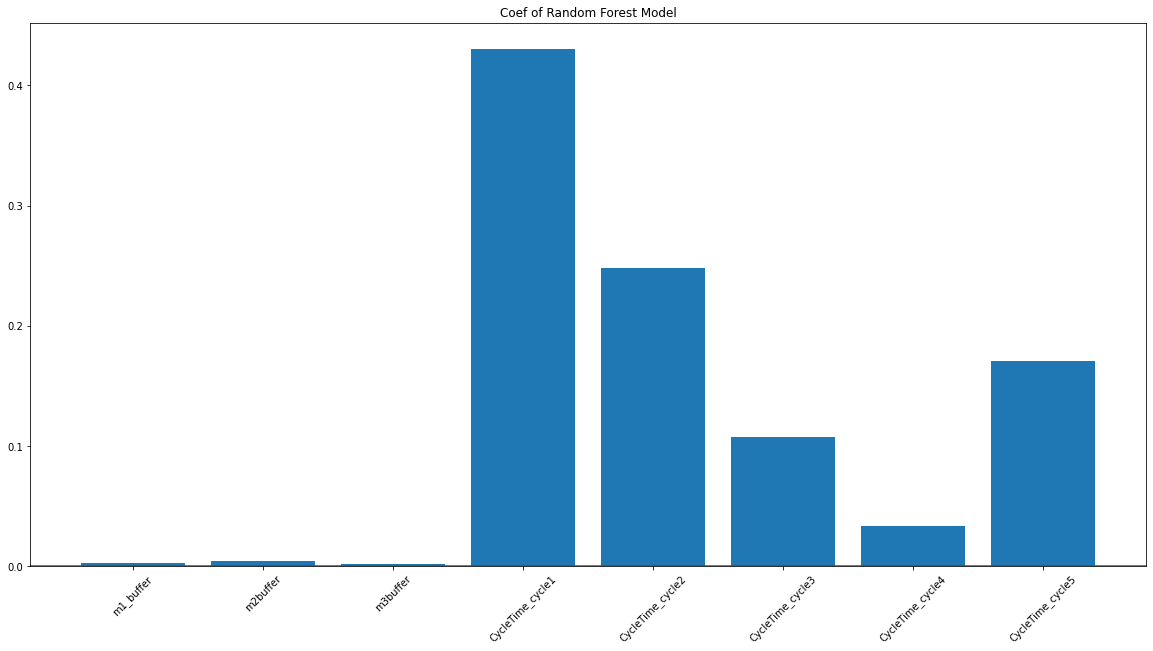

In [88]:
# Figure을 정의
plt.figure(figsize=(20,10))

# Ridge의 Coef를 barplot으로 그리기
plt.bar( train.drop(drop_cols,1).columns,  rf.feature_importances_ )

# y=0인 horizental한 선을 그리기
plt.axhline(y=0, color='r', linestyle='-')

plt.xticks(rotation=45)
plt.title("Coef of Random Forest Model");

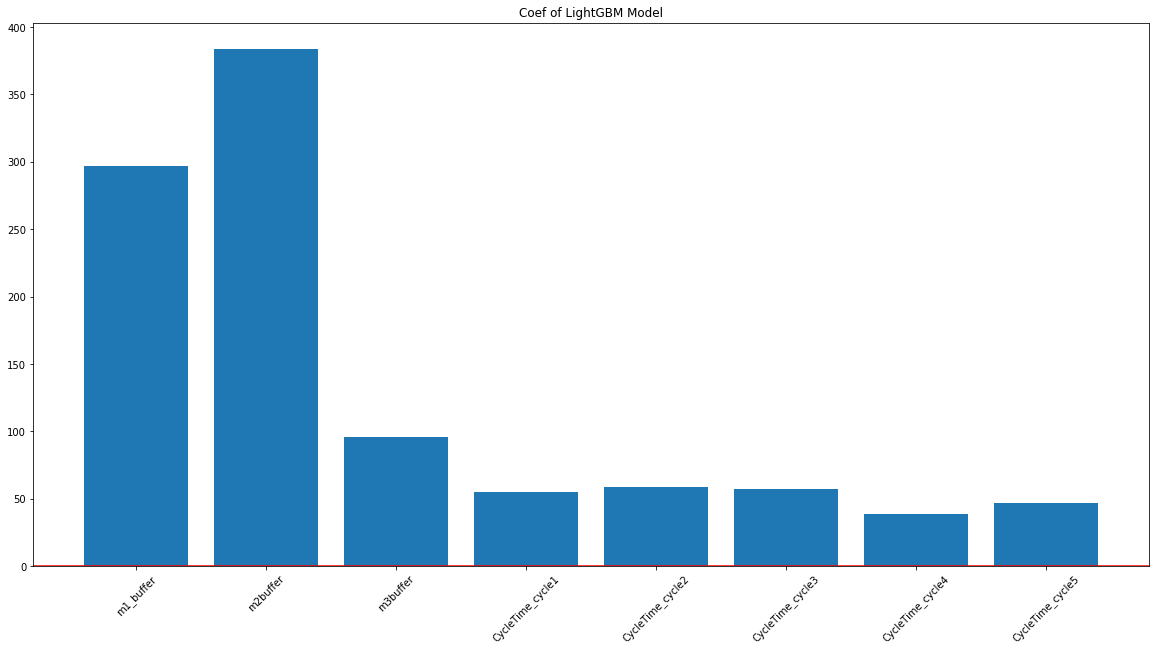

In [89]:
# Figure을 정의
plt.figure(figsize=(20,10))

# Ridge의 Coef를 barplot으로 그리기
plt.bar( train.drop(drop_cols,1).columns,  model.feature_importance() )

# y=0인 horizental한 선을 그리기
plt.axhline(y=0, color='r', linestyle='-')

plt.xticks(rotation=45)
plt.title("Coef of LightGBM Model");

## product1

In [114]:
# X_test_1=X_test.drop(['total', 'Uid', 'm3m1_product','conwip','m1_buffer_product' ,'m1m2_product','m2buffer_product','m2m3_product','m3buffer_product','CycleTime', 'Time', "Uid",'m3m1','m1m2','m2m3'],axis=1)

# time_1=X_test[X_test['CycleTime_cycle1']==1]
# time_3=X_test[X_test['CycleTime_cycle3']==1]
# time_4=X_test[X_test['CycleTime_cycle4']==1]
# time_5=X_test[X_test['CycleTime_cycle5']==1]

# df_24_drop_happy_1 = X_test_1[X_test_1['CycleTime_cycle1'] == 1]
# df_24_drop_happy_3 = X_test_1[X_test_1['CycleTime_cycle3'] == 1]
# df_24_drop_happy_4 = X_test_1[X_test_1['CycleTime_cycle4'] == 1]
# df_24_drop_happy_5 = X_test_1[X_test_1['CycleTime_cycle5'] == 1]

# df_24_drop_happy_1_1 = X_test[X_test_1['CycleTime_cycle1'] == 1]['CycleTime']
# df_24_drop_happy_3_1 = X_test[X_test_1['CycleTime_cycle3'] == 1]['CycleTime']
# df_24_drop_happy_4_1 = X_test[X_test_1['CycleTime_cycle4'] == 1]['CycleTime']
# df_24_drop_happy_5_1 = X_test[X_test_1['CycleTime_cycle5'] == 1]['CycleTime']

In [115]:
# w_preds=xgb_wrapper.predict(df_24_drop_happy_1)
# print(evaluate_regr(w_preds,df_24_drop_happy_1_1))

In [116]:
# aa=320
# aa_list=[]
# for i in range(1,len(w_preds)+1):
#     aa_list.append(aa)

# print(evaluate_regr(df_24_drop_happy_1_1,aa_list))

# print(evaluate_regr(df_24_drop_happy_1_1,w_preds))

In [118]:
# df_11 = pd.DataFrame({'real': (df_24_drop_happy_1_1),
#                       'pred':(w_preds),
#                       #'product_type': df_24_drop_sample_1['Product_type'],
#                       'time': time_1['Time'],
#                       'MVA_red': aa_list,
#                       #'MVA_green': cc_list,
#                       #'MVA_white': dd_list,
#                       #'MVA_black': ee_list,
#                      #'CycleTime':ct_list
#                       })

In [117]:
# plt.rcParams['figure.figsize'] = [25, 15]
# sns.pointplot(data=df_11, x="time", y="real")
# sns.pointplot(data=df_11, x="time", y="pred", color = 'gray')
# #sns.pointplot(data=df_11, x='time', y='MVA_red', color = 'red')
# sns.pointplot(data=df_11, x='time', y='MVA_red', color = 'red')
# #sns.lineplot(data=df_11, x='time', y='MVA_black', color = "black")
# #sns.lineplot(data=df_11, x='time', y='MVA_white', color = "gray")
# #sns.lineplot(data=df_11, x='time', y='MVA_green', color = "green")


# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

No handles with labels found to put in legend.


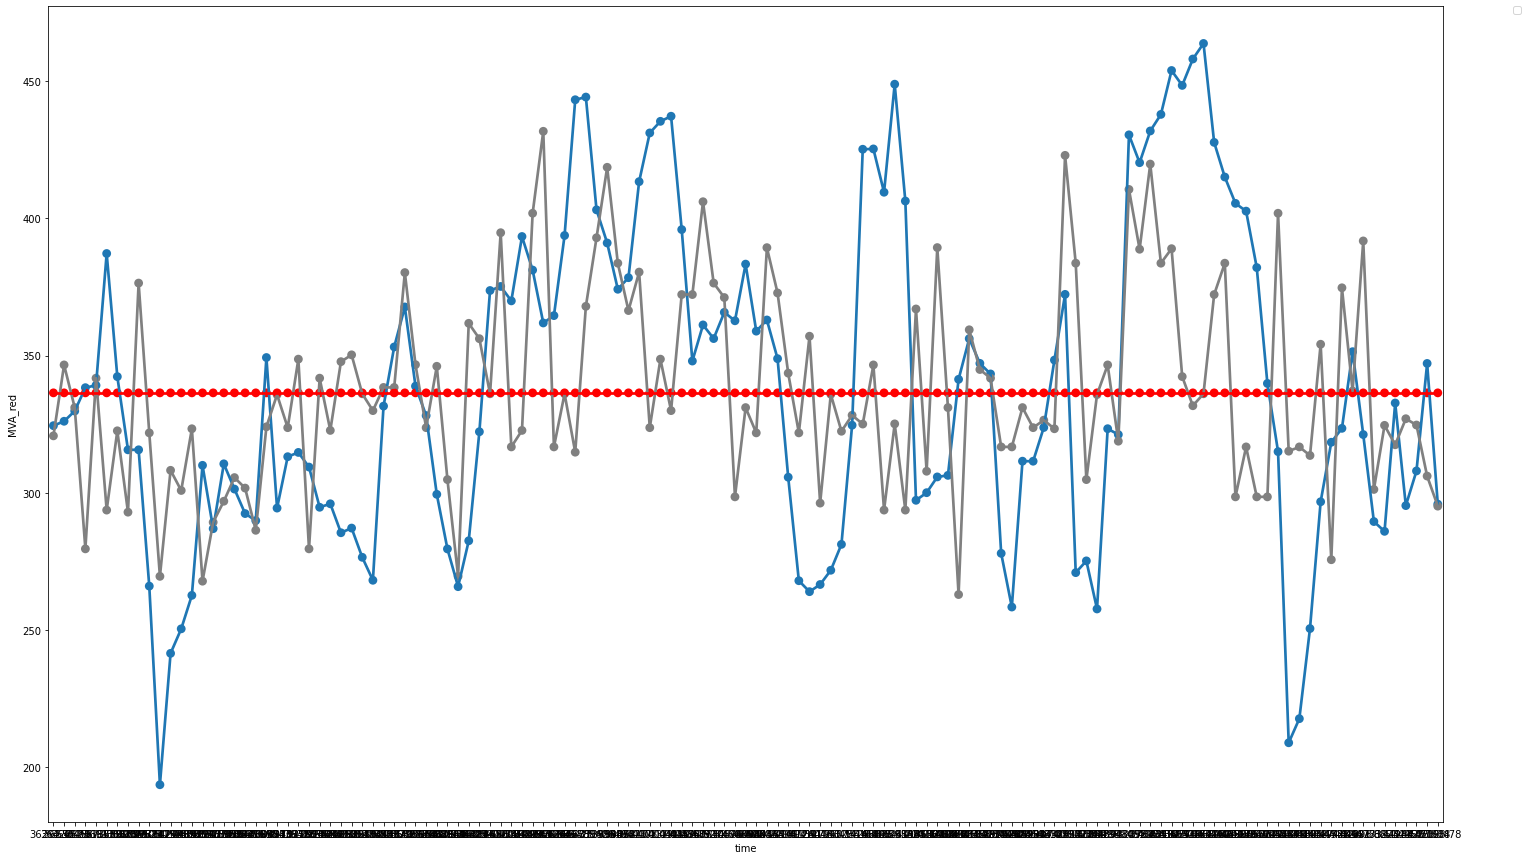

In [ ]:
df_11 = pd.DataFrame({'real': (df_24_drop_sample_1['CycleTime']),
                      'pred':(dt_pred*0.1 + rf_pred*0.2 + lgm_pred*0.7),
                      'product_type': df_24_drop_sample_1['Product_type'],
                      'time': df_24_drop_sample_1['Time'],
                      'MVA_red': aa_list,
                      #'MVA_green': cc_list,
                      #'MVA_white': dd_list,
                      #'MVA_black': ee_list,
                     #'CycleTime':ct_list
                      })

plt.rcParams['figure.figsize'] = [25, 15]
sns.pointplot(data=df_11, x="time", y="real")
sns.pointplot(data=df_11, x="time", y="pred", color = 'gray')
sns.pointplot(data=df_11, x='time', y='MVA_red', color = 'red')
#sns.lineplot(data=df_11, x='time', y='MVA_black', color = "black")
#sns.lineplot(data=df_11, x='time', y='MVA_white', color = "gray")
#sns.lineplot(data=df_11, x='time', y='MVA_green', color = "green")


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## product3

In [ ]:
lgm_pred=model.predict(df_24_drop_happy_1) #Light GBM
rf_pred = rf.predict(df_24_drop_happy_1) #Random Forest
dt_pred = dt.predict(df_24_drop_happy_1) #Decision Tree
lasso_pred = lasso.predict(df_24_drop_happy_1)
lr_pred = lr.predict(df_24_drop_happy_1)
xgb_pred = xgb_wrapper.predict(df_24_drop_happy_1)

evaluate_regr(lasso_pred, df_24_drop_happy_1_1)
evaluate_regr(rf_pred, df_24_drop_happy_1_1)
evaluate_regr(lgm_pred, df_24_drop_happy_1_1)
evaluate_regr(dt_pred , df_24_drop_happy_1_1)
evaluate_regr(lr_pred , df_24_drop_happy_1_1)
evaluate_regr(xgb_pred , df_24_drop_happy_1_1)

In [ ]:
lgm_pred=model.predict(df_24_drop_happy_3) #Light GBM
rf_pred = rf.predict(df_24_drop_happy_3) #Random Forest
dt_pred = dt.predict(df_24_drop_happy_3) #Decision Tree
lasso_pred = lasso.predict(df_24_drop_happy_3)
lr_pred = lr.predict(df_24_drop_happy_3)
xgb_pred = xgb_wrapper.predict(df_24_drop_happy_3)

evaluate_regr(lasso_pred, df_24_drop_happy_3_1)
evaluate_regr(rf_pred, df_24_drop_happy_3_1)
evaluate_regr(lgm_pred, df_24_drop_happy_3_1)
evaluate_regr(dt_pred , df_24_drop_happy_3_1)
evaluate_regr(lr_pred , df_24_drop_happy_3_1)
evaluate_regr(xgb_pred , df_24_drop_happy_3_1)

RMSLE: 0.0763128699, RMSE: 69.0871173097, MAE: 58.5040470341
RMSLE: 0.0796581262, RMSE: 72.5442609141, MAE: 58.6413940531
RMSLE: 0.0753213302, RMSE: 68.5918936164, MAE: 57.3066030538
RMSLE: 0.0846698895, RMSE: 77.6291160539, MAE: 61.4338628488
RMSLE: 0.0761388345, RMSE: 69.0217162563, MAE: 58.2271910646
RMSLE: 0.0775302641, RMSE: 71.3277094725, MAE: 56.8142242190


In [ ]:
cc=aa*3
cc_list=[]
for i in range(1,len(dt_pred*0.1 + rf_pred*0.2 + lgm_pred*0.7)+1):
    cc_list.append(cc)

print(evaluate_regr(df_24_drop_happy_3_1,cc_list))

RMSLE: 0.0919414228, RMSE: 83.1299574005, MAE: 71.2900088465
None


No handles with labels found to put in legend.


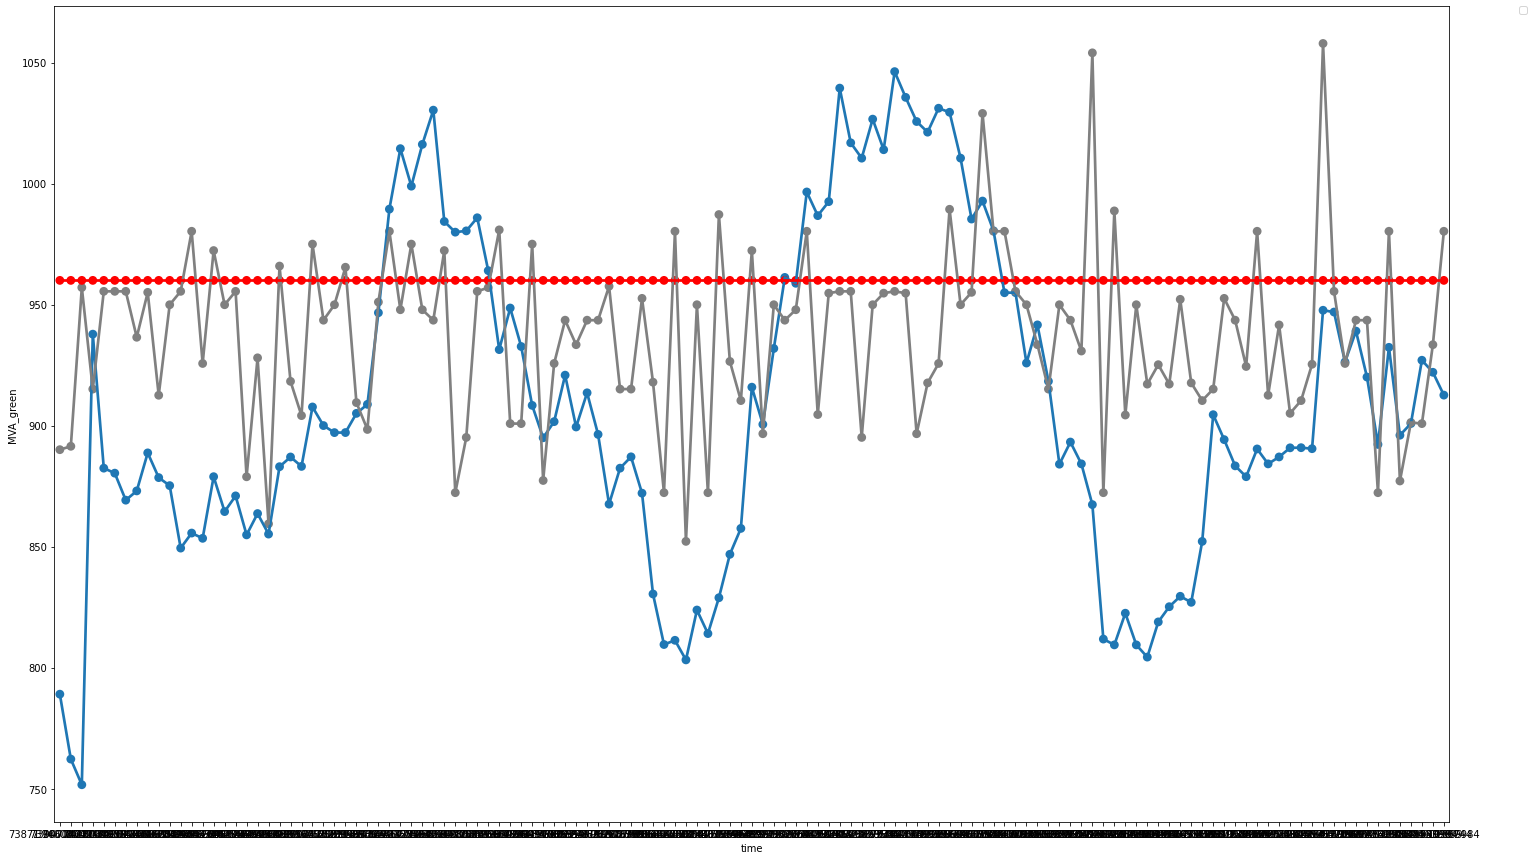

In [ ]:
df_11 = pd.DataFrame({'real': (df_24_drop_happy_3_1),
                      'pred':(rf_pred),
                      'product_type': df_24_drop_happy_3_1,
                      'time': time_3['Time'],
                      #'MVA_red': aa_list,
                      'MVA_green': cc_list,
                      #'MVA_white': dd_list,
                      #'MVA_black': ee_list,
                     #'CycleTime':ct_list
                      })

plt.rcParams['figure.figsize'] = [25, 15]
sns.pointplot(data=df_11, x="time", y="real")
sns.pointplot(data=df_11, x="time", y="pred", color = 'gray')
#sns.pointplot(data=df_11, x='time', y='MVA_red', color = 'red')
#sns.lineplot(data=df_11, x='time', y='MVA_black', color = "black")
#sns.lineplot(data=df_11, x='time', y='MVA_white', color = "gray")
sns.pointplot(data=df_11, x='time', y='MVA_green', color = "red")


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

No handles with labels found to put in legend.


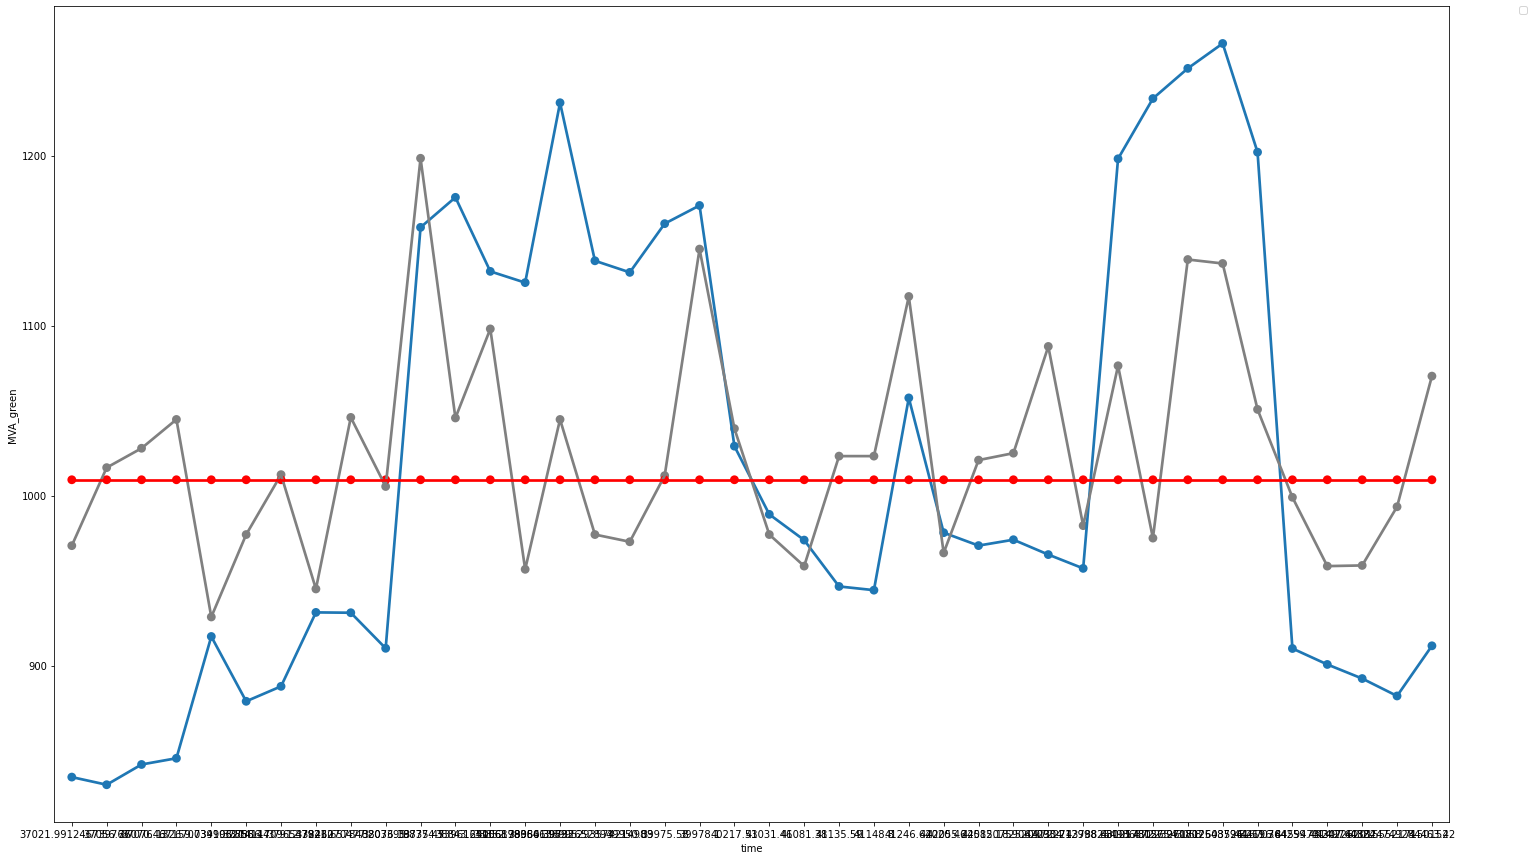

In [ ]:
df_11 = pd.DataFrame({'real': (df_24_drop_sample_3['CycleTime']),
                      'pred':(dt_pred*0.1 + rf_pred*0.2 + lgm_pred*0.7),
                      'product_type': df_24_drop_sample_3['Product_type'],
                      'time': df_24_drop_sample_3['Time'],
                      #'MVA_red': aa_list,
                      'MVA_green': cc_list,
                      #'MVA_white': dd_list,
                      #'MVA_black': ee_list,
                     #'CycleTime':ct_list
                      })

plt.rcParams['figure.figsize'] = [25, 15]
sns.pointplot(data=df_11, x="time", y="real")
sns.pointplot(data=df_11, x="time", y="pred", color = 'gray')
#sns.lineplot(data=df_11, x='time', y='MVA_red', color = 'red')
#sns.lineplot(data=df_11, x='time', y='MVA_black', color = "black")
#sns.lineplot(data=df_11, x='time', y='MVA_white', color = "gray")
sns.pointplot(data=df_11,x="time", y='MVA_green', color = "red")


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## product4

In [ ]:
lgm_pred=model.predict(df_24_drop_happy_3) #Light GBM
rf_pred = rf.predict(df_24_drop_happy_3) #Random Forest
dt_pred = dt.predict(df_24_drop_happy_3) #Decision Tree
lasso_pred = lasso.predict(df_24_drop_happy_3)
lr_pred = lr.predict(df_24_drop_happy_3)
xgb_pred = xgb_wrapper.predict(df_24_drop_happy_3)

evaluate_regr(lasso_pred, df_24_drop_happy_3_1)
evaluate_regr(rf_pred, df_24_drop_happy_3_1)
evaluate_regr(lgm_pred, df_24_drop_happy_3_1)
evaluate_regr(dt_pred , df_24_drop_happy_3_1)
evaluate_regr(lr_pred , df_24_drop_happy_3_1)
evaluate_regr(xgb_pred , df_24_drop_happy_3_1)

In [ ]:
lgm_pred=model.predict(df_24_drop_happy_4) #Light GBM
rf_pred = rf.predict(df_24_drop_happy_4) #Random Forest
dt_pred = dt.predict(df_24_drop_happy_4) #Decision Tree
lasso_pred = lasso.predict(df_24_drop_happy_4)
lr_pred = lr.predict(df_24_drop_happy_4)
xgb_pred = xgb_wrapper.predict(df_24_drop_happy_4)

evaluate_regr(lasso_pred, df_24_drop_happy_4_1)
evaluate_regr(rf_pred, df_24_drop_happy_4_1)
evaluate_regr(lgm_pred, df_24_drop_happy_4_1)
evaluate_regr(dt_pred , df_24_drop_happy_4_1)
evaluate_regr(lr_pred , df_24_drop_happy_4_1)
evaluate_regr(xgb_pred , df_24_drop_happy_4_1)

RMSLE: 0.0618744757, RMSE: 74.6710947693, MAE: 63.7334020319
RMSLE: 0.0690452691, RMSE: 84.7566273714, MAE: 70.5342352720
RMSLE: 0.0630694294, RMSE: 76.6552614743, MAE: 63.7256188199
RMSLE: 0.0727584974, RMSE: 89.3922745043, MAE: 72.9909079382
RMSLE: 0.0643466907, RMSE: 77.7875756079, MAE: 66.3098499419
RMSLE: 0.0706362966, RMSE: 86.7455747951, MAE: 72.0140369201


In [ ]:
dd=aa*4
dd_list=[]
for i in range(1,len(dt_pred*0.1 + rf_pred*0.2 + lgm_pred*0.7)+1):
    dd_list.append(dd)

print(evaluate_regr(df_24_drop_happy_4_1,dd_list))


RMSLE: 0.0779148430, RMSE: 94.6462097110, MAE: 80.4267693963
None


No handles with labels found to put in legend.


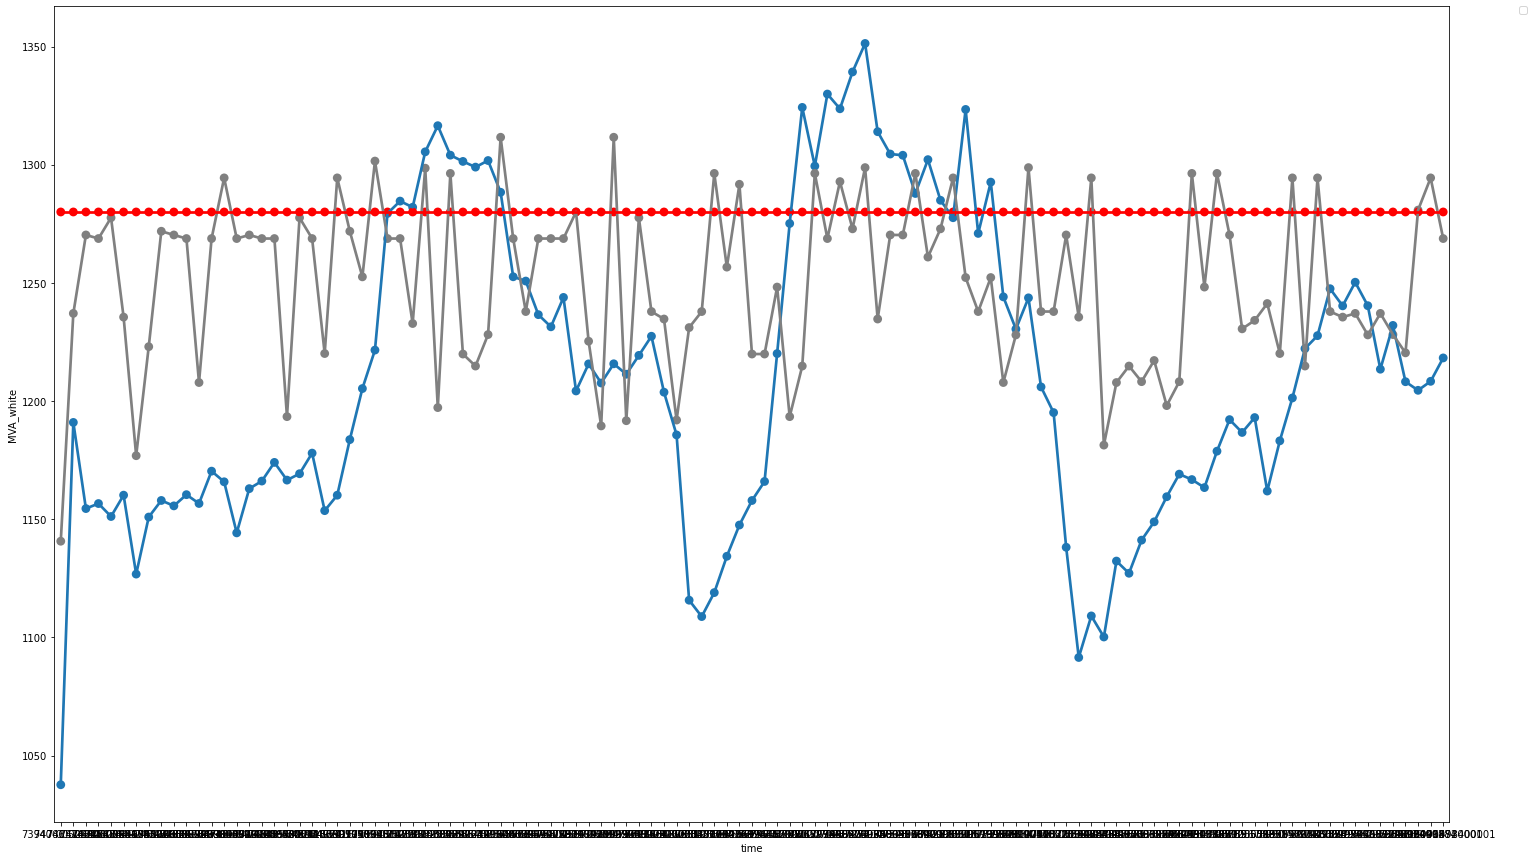

In [ ]:
df_11 = pd.DataFrame({'real': (df_24_drop_happy_4_1),
                      'pred':(lgm_pred),
                      #'product_type': df_24_drop_sample_4['Product_type'],
                      'time': time_4['Time'],
                      #'MVA_red': aa_list,
                      #'MVA_green': cc_list,
                      'MVA_white': dd_list,
                      #'MVA_black': ee_list,
                     #'CycleTime':ct_list
                      })

plt.rcParams['figure.figsize'] = [25, 15]
sns.pointplot(data=df_11, x="time", y="real")
sns.pointplot(data=df_11, x="time", y="pred", color = 'gray')
#sns.lineplot(data=df_11, x='time', y='MVA_red', color = 'red')
#sns.lineplot(data=df_11, x='time', y='MVA_black', color = "black")
sns.pointplot(data=df_11, x='time', y='MVA_white', color = "red")
#sns.lineplot(data=df_11, x='time', y='MVA_green', color = "green")


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## product5

In [ ]:
lgm_pred=model.predict(df_24_drop_happy_3) #Light GBM
rf_pred = rf.predict(df_24_drop_happy_3) #Random Forest
dt_pred = dt.predict(df_24_drop_happy_3) #Decision Tree
lasso_pred = lasso.predict(df_24_drop_happy_3)
lr_pred = lr.predict(df_24_drop_happy_3)
xgb_pred = xgb_wrapper.predict(df_24_drop_happy_3)

evaluate_regr(lasso_pred, df_24_drop_happy_3_1)
evaluate_regr(rf_pred, df_24_drop_happy_3_1)
evaluate_regr(lgm_pred, df_24_drop_happy_3_1)
evaluate_regr(dt_pred , df_24_drop_happy_3_1)
evaluate_regr(lr_pred , df_24_drop_happy_3_1)
evaluate_regr(xgb_pred , df_24_drop_happy_3_1)

In [ ]:
lgm_pred=model.predict(df_24_drop_happy_5) #Light GBM
rf_pred = rf.predict(df_24_drop_happy_5) #Random Forest
dt_pred = dt.predict(df_24_drop_happy_5) #Decision Tree
lasso_pred = lasso.predict(df_24_drop_happy_5)
lr_pred = lr.predict(df_24_drop_happy_5)
xgb_pred = xgb_wrapper.predict(df_24_drop_happy_5)

evaluate_regr(lasso_pred, df_24_drop_happy_5_1)
evaluate_regr(rf_pred, df_24_drop_happy_5_1)
evaluate_regr(lgm_pred, df_24_drop_happy_5_1)
evaluate_regr(dt_pred , df_24_drop_happy_5_1)
evaluate_regr(lr_pred , df_24_drop_happy_5_1)
evaluate_regr(xgb_pred , df_24_drop_happy_5_1)

RMSLE: 0.0515899930, RMSE: 78.2807687387, MAE: 64.4918597365
RMSLE: 0.0623728746, RMSE: 96.6766643994, MAE: 77.4572023533
RMSLE: 0.0502729209, RMSE: 76.6652664791, MAE: 61.8684426863
RMSLE: 0.0687822554, RMSE: 106.5070924596, MAE: 84.7445680531
RMSLE: 0.0554571678, RMSE: 84.4831991587, MAE: 69.8125487287
RMSLE: 0.0649368949, RMSE: 101.0546629462, MAE: 79.6414382372


In [ ]:
ee=aa*5*0.9995
ee_list=[]
for i in range(1,len(dt_pred*0.1 + rf_pred*0.2 + lgm_pred*0.7)+1):
    ee_list.append(ee)

print(evaluate_regr(df_24_drop_happy_5_1,ee_list))

RMSLE: 0.0650851673, RMSE: 99.5919457806, MAE: 85.2121816125
None


No handles with labels found to put in legend.


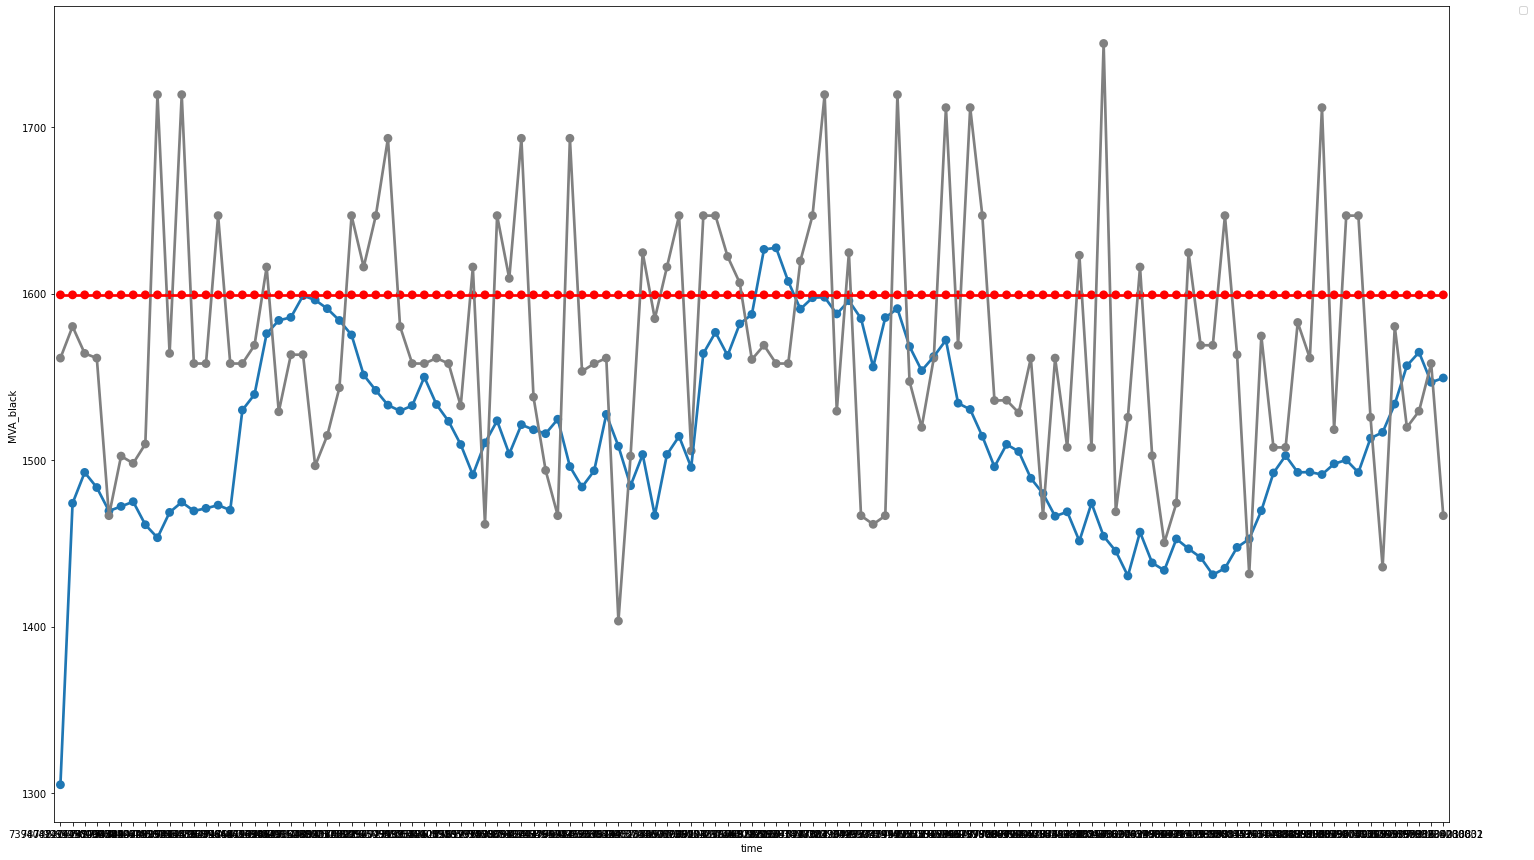

In [ ]:
df_11 = pd.DataFrame({'real': (df_24_drop_happy_5_1),
                      'pred':(xgb_pred),
                      #'product_type': df_24_drop_sample_5['Product_type'],
                      'time': time_5['Time'],
                      #'MVA_red': aa_list,
                      #'MVA_green': cc_list,
                      #'MVA_white': dd_list,
                      'MVA_black': ee_list,
                     #'CycleTime':ct_list
                      })

plt.rcParams['figure.figsize'] = [25, 15]
sns.pointplot(data=df_11, x="time", y="real")
sns.pointplot(data=df_11, x="time", y="pred", color = 'gray')
#sns.lineplot(data=df_11, x='time', y='MVA_red', color = 'red')
sns.pointplot(data=df_11, x='time', y='MVA_black', color = "red")
#sns.lineplot(data=df_11, x='time', y='MVA_white', color = "gray")
#sns.lineplot(data=df_11, x='time', y='MVA_green', color = "green")


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# 제품별로 5-fold 검증

* 실제 모델로 구현시키기에는 부적절

In [ ]:
# # 선언
# train_label = df_777['CycleTime']
# train = df_777.copy()
# drop_cols = ['CycleTime', 'Time', 'Uid']
# #, 'm3m1_product','conwip','m1_buffer_product' ,'m1m2_product','m2buffer_product','m2m3_product','m3buffer_product'
# # 각 모델에 대한 oof 정의
# lr_oof_train = np.zeros((train.shape[0]))
# ridge_oof_train = np.zeros((train.shape[0]))
# lasso_oof_train = np.zeros((train.shape[0]))
# dt_oof_train = np.zeros((train.shape[0]))
# rf_oof_train = np.zeros((train.shape[0]))
# svr_oof_train = np.zeros((train.shape[0]))
# lgbm_oof_train = np.zeros((train.shape[0]))
# w_oof_train = np.zeros((train.shape[0]))

# lr_oof_test = np.zeros((df_24_drop.shape[0]))
# ridge_oof_test = np.zeros((df_24_drop.shape[0]))
# lasso_oof_test = np.zeros((df_24_drop.shape[0]))
# dt_oof_test = np.zeros((df_24_drop.shape[0]))
# rf_oof_test = np.zeros((df_24_drop.shape[0]))
# svr_oof_test = np.zeros((df_24_drop.shape[0]))
# lgbm_oof_test = np.zeros((df_24_drop.shape[0]))
# w_oof_test = np.zeros((df_24_drop.shape[0]))

# lr_oof_test_pr1 = np.zeros((df_24_drop_happy_1.shape[0]))
# ridge_oof_test_pr1 = np.zeros((df_24_drop_happy_1.shape[0]))
# lasso_oof_test_pr1 = np.zeros((df_24_drop_happy_1.shape[0]))
# dt_oof_test_pr1 = np.zeros((df_24_drop_happy_1.shape[0]))
# rf_oof_test_pr1 = np.zeros((df_24_drop_happy_1.shape[0]))
# svr_oof_test_pr1 = np.zeros((df_24_drop_happy_1.shape[0]))
# lgbm_oof_test_pr1 = np.zeros((df_24_drop_happy_1.shape[0]))
# w_oof_test_pr1 = np.zeros((df_24_drop_happy_1.shape[0]))

# lr_oof_test_pr2 = np.zeros((df_24_drop_happy_3.shape[0]))
# ridge_oof_test_pr2 = np.zeros((df_24_drop_happy_3.shape[0]))
# lasso_oof_test_pr2 = np.zeros((df_24_drop_happy_3.shape[0]))
# dt_oof_test_pr2 = np.zeros((df_24_drop_happy_3.shape[0]))
# rf_oof_test_pr2 = np.zeros((df_24_drop_happy_3.shape[0]))
# svr_oof_test_pr2 = np.zeros((df_24_drop_happy_3.shape[0]))
# lgbm_oof_test_pr2 = np.zeros((df_24_drop_happy_3.shape[0]))
# w_oof_test_pr2 = np.zeros((df_24_drop_happy_3.shape[0]))

# lr_oof_test_pr3 = np.zeros((df_24_drop_happy_4.shape[0]))
# ridge_oof_test_pr3 = np.zeros((df_24_drop_happy_4.shape[0]))
# lasso_oof_test_pr3 = np.zeros((df_24_drop_happy_4.shape[0]))
# dt_oof_test_pr3 = np.zeros((df_24_drop_happy_4.shape[0]))
# rf_oof_test_pr3 = np.zeros((df_24_drop_happy_4.shape[0]))
# svr_oof_test_pr3 = np.zeros((df_24_drop_happy_4.shape[0]))
# lgbm_oof_test_pr3 = np.zeros((df_24_drop_happy_4.shape[0]))
# w_oof_test_pr3 = np.zeros((df_24_drop_happy_4.shape[0]))

# lr_oof_test_pr4 = np.zeros((df_24_drop_happy_5.shape[0]))
# ridge_oof_test_pr4 = np.zeros((df_24_drop_happy_5.shape[0]))
# lasso_oof_test_pr4 = np.zeros((df_24_drop_happy_5.shape[0]))
# dt_oof_test_pr4 = np.zeros((df_24_drop_happy_5.shape[0]))
# rf_oof_test_pr4 = np.zeros((df_24_drop_happy_5.shape[0]))
# svr_oof_test_pr4 = np.zeros((df_24_drop_happy_5.shape[0]))
# lgbm_oof_test_pr4 = np.zeros((df_24_drop_happy_5.shape[0]))
# w_oof_test_pr4 = np.zeros((df_24_drop_happy_5.shape[0]))


# # Kfold 정의
# kfolds = KFold(n_splits=n_splits, random_state=2021, shuffle=True)

# # Fold별로 학습진행
# for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
#     # Train/Valid-set을 정의하기
#     X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
#     X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    
#     # (0) Linear
#     print("---TRAINING LINEAR---")
#     lr = LinearRegression()
    
#     lr.fit(X_train, y_train)
    
#     lr_valid_pred = lr.predict(X_valid)
#     lr_oof_train[val_ind] = lr_valid_pred    
    
#     lr_test_pred = lr.predict(df_24_drop)
#     lr_oof_test += lr_test_pred/n_splits 
#     lr_test_pred = lr.predict(df_24_drop_happy_1)
#     lr_oof_test_pr1 += lr_test_pred/n_splits     
#     lr_test_pred = lr.predict(df_24_drop_happy_3)
#     lr_oof_test_pr2 += lr_test_pred/n_splits 
#     lr_test_pred = lr.predict(df_24_drop_happy_4)
#     lr_oof_test_pr3 += lr_test_pred/n_splits 
#     lr_test_pred = lr.predict(df_24_drop_happy_5)
#     lr_oof_test_pr4 += lr_test_pred/n_splits 

#     # (1) Ridge
#     print("---TRAINING RIDGE---")
#     ridge = Ridge(random_state = 2021)
    
#     ridge.fit(X_train, y_train)
    
#     ridge_valid_pred = ridge.predict(X_valid)
#     ridge_oof_train[val_ind] = ridge_valid_pred

#     ridge_test_pred = ridge.predict(df_24_drop)
#     ridge_oof_test += ridge_test_pred/ n_splits 
#     ridge_test_pred = ridge.predict(df_24_drop_happy_1)
#     ridge_oof_test_pr1 += ridge_test_pred/ n_splits 
#     ridge_test_pred = ridge.predict(df_24_drop_happy_3)
#     ridge_oof_test_pr2 += ridge_test_pred/ n_splits 
#     ridge_test_pred = ridge.predict(df_24_drop_happy_4)
#     ridge_oof_test_pr3 += ridge_test_pred/ n_splits 
#     ridge_test_pred = ridge.predict(df_24_drop_happy_5)
#     ridge_oof_test_pr4 += ridge_test_pred/ n_splits       
    
#     # (2) Lasso
#     print("---TRAINING LASSO---")
#     lasso = Lasso(random_state = 2021)
    
#     lasso.fit(X_train, y_train)
    
#     lasso_valid_pred = lasso.predict(X_valid)
#     lasso_oof_train[val_ind] = lasso_valid_pred

#     lasso_test_pred = lasso.predict(df_24_drop)
#     lasso_oof_test += lasso_test_pred/ n_splits  
#     lasso_test_pred = lasso.predict(df_24_drop_happy_1)
#     lasso_oof_test_pr1 += lasso_test_pred/ n_splits  
#     lasso_test_pred = lasso.predict(df_24_drop_happy_3)
#     lasso_oof_test_pr2 += lasso_test_pred/ n_splits  
#     lasso_test_pred = lasso.predict(df_24_drop_happy_4)
#     lasso_oof_test_pr3 += lasso_test_pred/ n_splits  
#     lasso_test_pred = lasso.predict(df_24_drop_happy_5)
#     lasso_oof_test_pr4 += lasso_test_pred/ n_splits     
    
    
#     # (3) Decision Tree
#     print("---TRAINING DECISION TREE---")
#     dt = DecisionTreeRegressor(random_state=2021)
    
#     dt.fit(X_train, y_train)
    
#     dt_valid_pred = dt.predict(X_valid)
#     dt_oof_train[val_ind] = dt_valid_pred
    
#     dt_test_pred = dt.predict(df_24_drop)
#     dt_oof_test += dt_test_pred/ n_splits 
#     dt_test_pred = dt.predict(df_24_drop_happy_1)
#     dt_oof_test_pr1 += dt_test_pred/ n_splits 
#     dt_test_pred = dt.predict(df_24_drop_happy_3)
#     dt_oof_test_pr2 += dt_test_pred/ n_splits 
#     dt_test_pred = dt.predict(df_24_drop_happy_4)
#     dt_oof_test_pr3 += dt_test_pred/ n_splits 
#     dt_test_pred = dt.predict(df_24_drop_happy_5)
#     dt_oof_test_pr4 += dt_test_pred/ n_splits 

#     # (4) Random Forest
#     print("---TRAINING RANDOM FOREST---")
#     rf = RandomForestRegressor(random_state=2021, n_estimators=20 )
    
#     rf.fit(X_train, y_train)
    
#     rf_valid_pred = rf.predict(X_valid)
#     rf_oof_train[val_ind] = rf_valid_pred
    
#     rf_test_pred = rf.predict(df_24_drop)
#     rf_oof_test += rf_test_pred/ n_splits 
#     rf_test_pred = rf.predict(df_24_drop_happy_1)
#     rf_oof_test_pr1 += rf_test_pred/ n_splits 
#     rf_test_pred = rf.predict(df_24_drop_happy_3)
#     rf_oof_test_pr2 += rf_test_pred/ n_splits 
#     rf_test_pred = rf.predict(df_24_drop_happy_4)
#     rf_oof_test_pr3 += rf_test_pred/ n_splits 
#     rf_test_pred = rf.predict(df_24_drop_happy_5)
#     rf_oof_test_pr4 += rf_test_pred/ n_splits   

#     # (5) XGB
#     print("---TRAINING XGBRegressor---")
#     xgb_wrapper = XGBRegressor(n_estimators = 1000, learning_rate = 0.05, max_depth = 10,objective='reg:squarederror', booster='gbtree',eval_metric='rmse')
#     xgb_wrapper.fit(X_train, y_train)

#     w_valid_pred = xgb_wrapper.predict(X_valid)
#     w_oof_train[val_ind] = w_valid_pred

#     w_test_pred = xgb_wrapper.predict(df_24_drop)
#     w_oof_test += w_test_pred/ n_splits 
#     w_test_pred = xgb_wrapper.predict(df_24_drop_happy_1)
#     w_oof_test_pr1 += w_test_pred/ n_splits 
#     w_test_pred = xgb_wrapper.predict(df_24_drop_happy_3)
#     w_oof_test_pr2 += w_test_pred/ n_splits 
#     w_test_pred = xgb_wrapper.predict(df_24_drop_happy_4)
#     w_oof_test_pr3 += w_test_pred/ n_splits 
#     w_test_pred = xgb_wrapper.predict(df_24_drop_happy_5)
#     w_oof_test_pr4 += w_test_pred/ n_splits    
    
#     # (6) Light GBM
#     print("---TRAINING LIGHT GBM---")
#     # dtrain/dvalid 정의
#     dtrain = lgbm.Dataset(X_train, y_train)
#     dvalid = lgbm.Dataset(X_valid, y_valid)
    
#     # model 정의&학습
#     model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
#                        valid_sets=(dtrain, dvalid), 
#                        valid_names=('train','valid'), 
#                        verbose_eval= 5)
    
#     # local_valid/local_test에 대한 예측
#     lgbm_valid_pred = model.predict(X_valid)
        
#     lgbm_oof_train[val_ind] = lgbm_valid_pred
#     print('='*80)

#     lgbm_test_pred = model.predict(df_24_drop)
#     lgbm_oof_test += lgbm_test_pred/ n_splits
#     lgbm_test_pred = model.predict(df_24_drop_happy_1)
#     lgbm_oof_test_pr1 += lgbm_test_pred/ n_splits
#     lgbm_test_pred = model.predict(df_24_drop_happy_3)
#     lgbm_oof_test_pr2 += lgbm_test_pred/ n_splits
#     lgbm_test_pred = model.predict(df_24_drop_happy_4)
#     lgbm_oof_test_pr3 += lgbm_test_pred/ n_splits
#     lgbm_test_pred = model.predict(df_24_drop_happy_5)
#     lgbm_oof_test_pr4 += lgbm_test_pred/ n_splits
#     print('='*80)
    
# print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")
    
    
# print("<Linear> OVERALL:", evaluate_regr(train_label,lr_oof_train))   
# print('-'*80)
# print("<Ridge> OVERALL:", evaluate_regr(train_label,ridge_oof_train))
# print('-'*80)
# print("<Lasso> OVERALL:", evaluate_regr(train_label,lasso_oof_train))
# print('-'*80)
# print("<Decision-Tree> OVERALL:", evaluate_regr(train_label,dt_oof_train))
# print('-'*80)
# print("<Random-Forest> OVERALL:", evaluate_regr(train_label,rf_oof_train))
# print('-'*80)
# print("<XGBoost> OVERALL:", evaluate_regr(train_label,w_oof_train))
# print('-'*80)
# print("<Light-GBM> OVERALL:", evaluate_regr(train_label,lgbm_oof_train))